## Variation of spt matrix with time_all tracks together

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
import matplotlib.cm as cm
from scipy import stats

In [2]:
# Load the CSV file
file_path = r'Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\no_drug\Analysed Data\2x\Trackmate analysis new 07052024\csv files\window_size_5\flagged tracks\20240118_UGD-2x-2s-replicate1-FOV-2_with_cellIDs_with_step_sizes-wstepflags.csv' 
data = pd.read_csv(file_path)

In [3]:
# Ensure step_flag is boolean and filter for True values
data['step_flag'] = data['step_flag'].astype(str).str.upper() == 'TRUE'

In [4]:
# Helper function to check for consecutive True values
def has_consecutive_true(df, col='step_flag'):
    return df[col].rolling(window=2).apply(lambda x: all(x), raw=True).any()

# Filter track IDs with consecutive True values
valid_track_ids = data.groupby('trackID').filter(has_consecutive_true)['trackID'].unique()
if len(valid_track_ids) == 0:
    raise ValueError("No trackIDs found with consecutive TRUE values in step_flag.")

In [5]:
# MSD calculation function
def calc_MSD(df_track, lags):
    df_track_sorted = df_track.sort_values("t")
    MSDs = []
    for lag in lags:
        Xs = np.array(df_track_sorted.x, dtype=float)
        Ys = np.array(df_track_sorted.y, dtype=float)
        SquareDisplacements = (Xs[lag:] - Xs[:-lag]) ** 2 + (Ys[lag:] - Ys[:-lag]) ** 2
        MSD = np.nanmean(SquareDisplacements)
        MSDs.append(MSD)
    return np.array(MSDs, dtype=float)

In [6]:
# Set unit conversions
um_per_pixel = 0.117
s_per_frame = 2

In [7]:
# Running window analysis settings
window_size = 20
lags = np.linspace(1, window_size, window_size).astype(int)
minimal_datapoints = 5

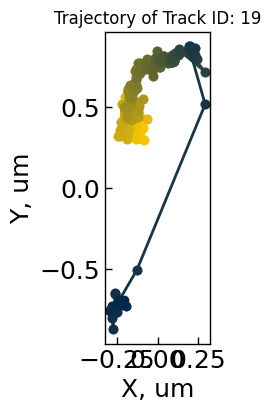

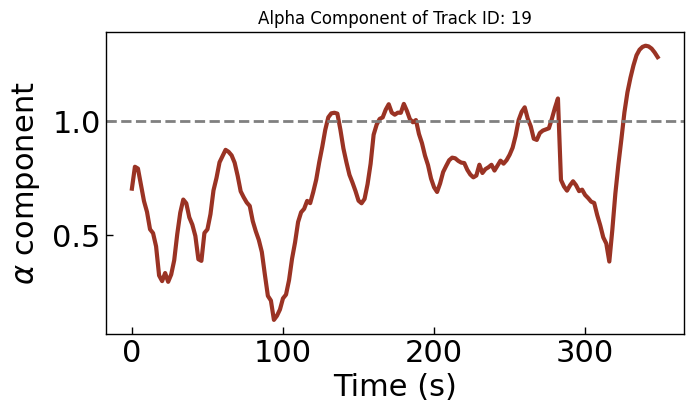

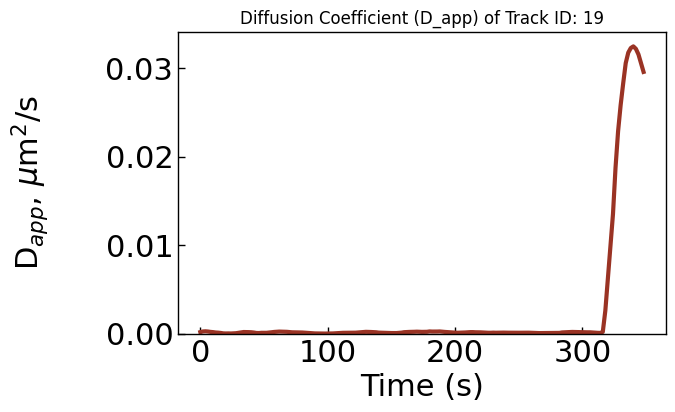

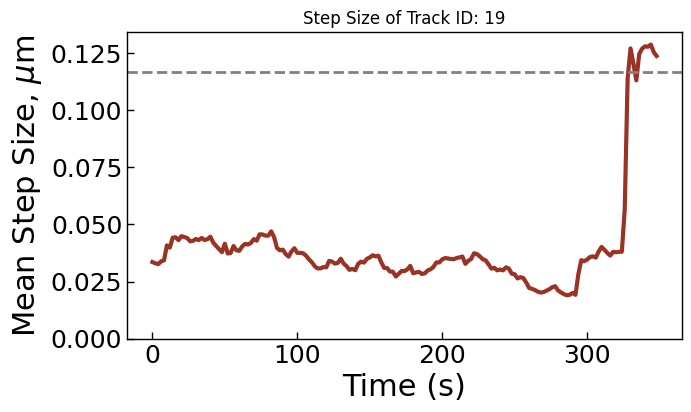

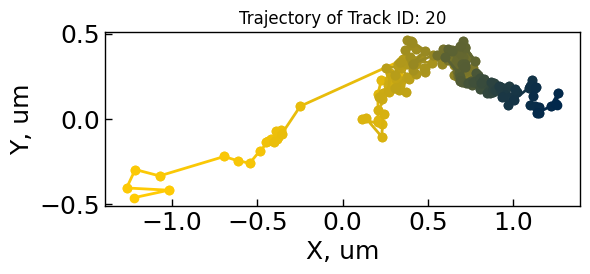

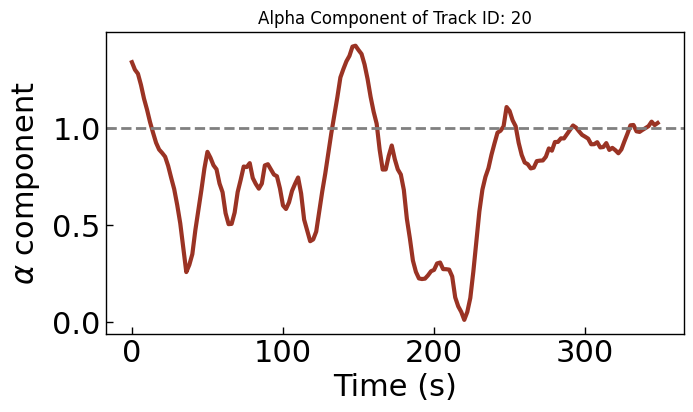

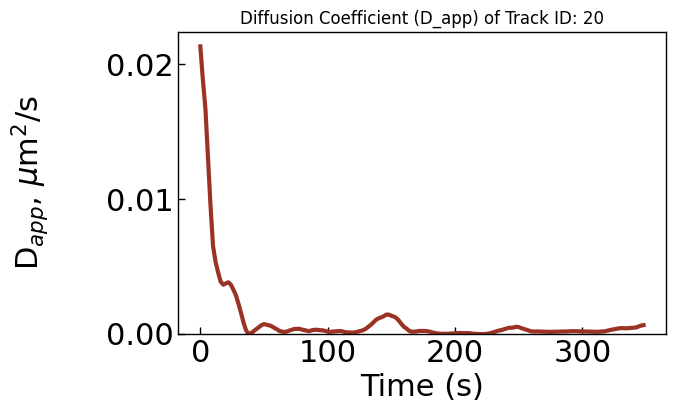

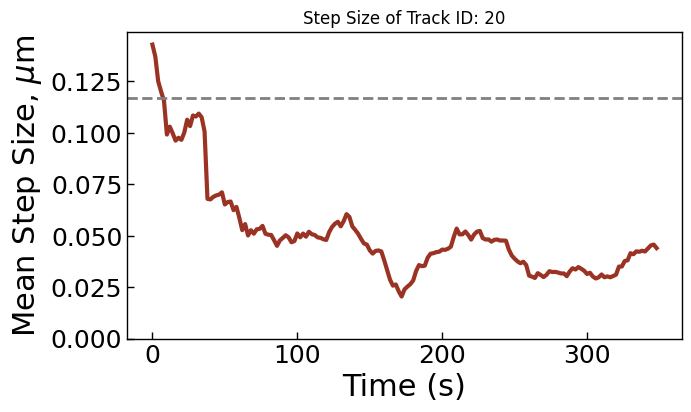

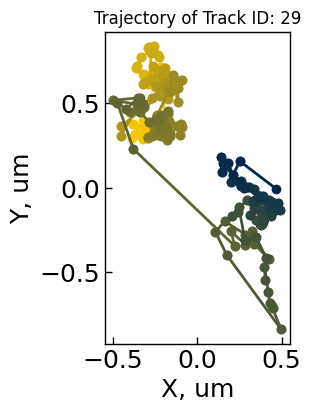

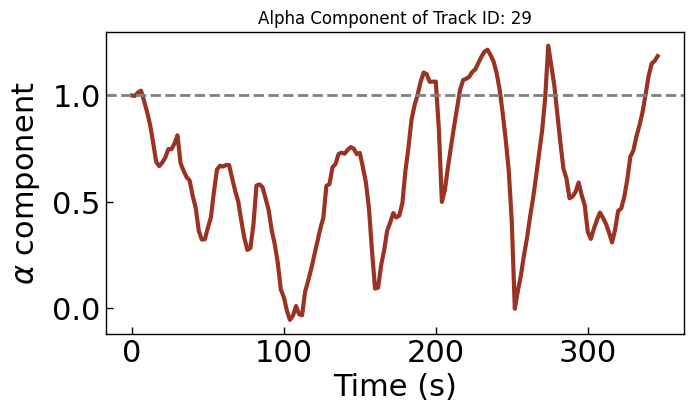

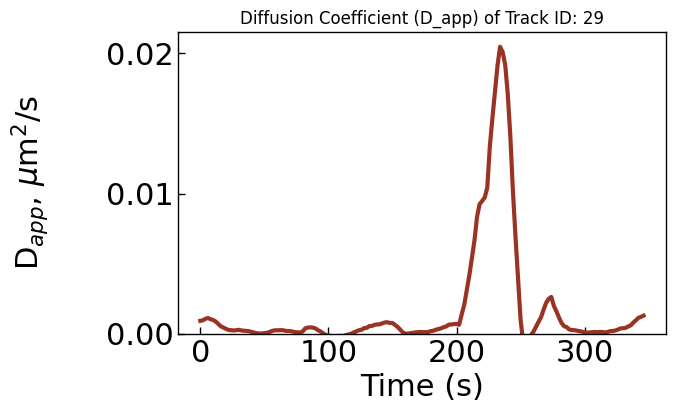

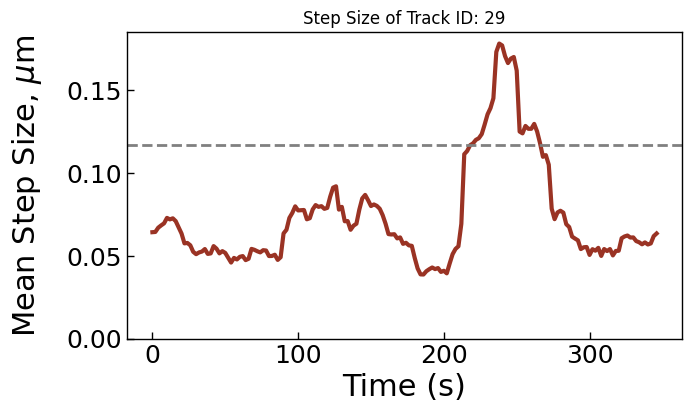

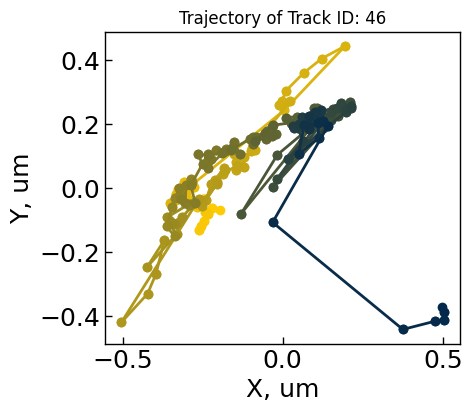

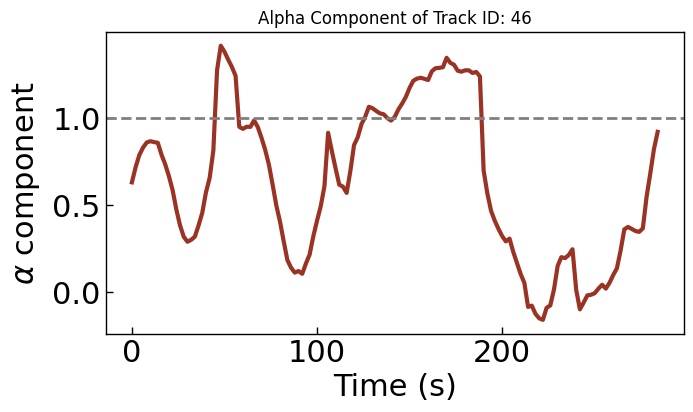

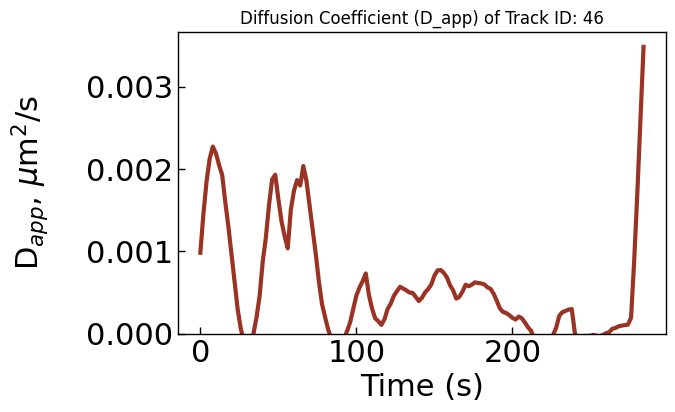

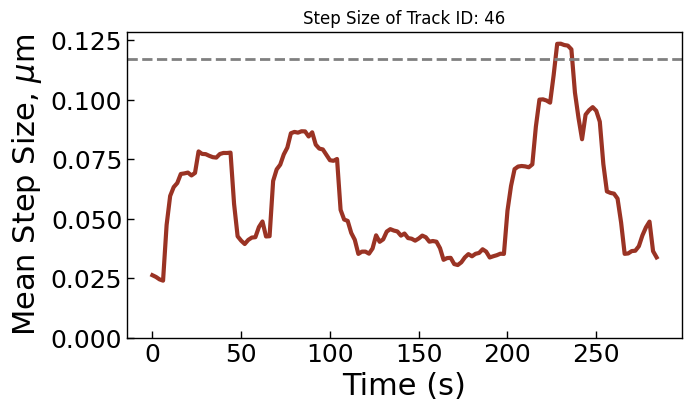

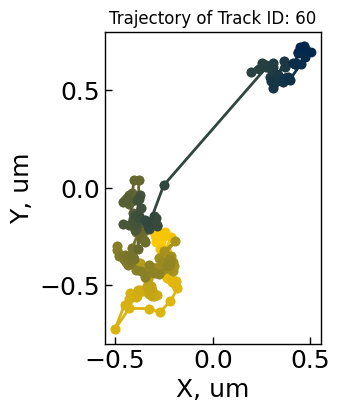

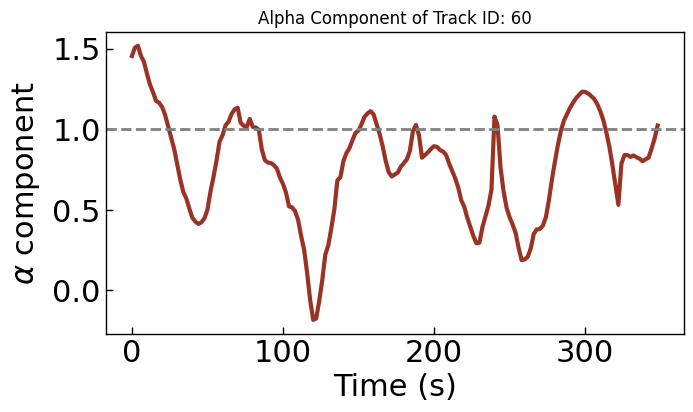

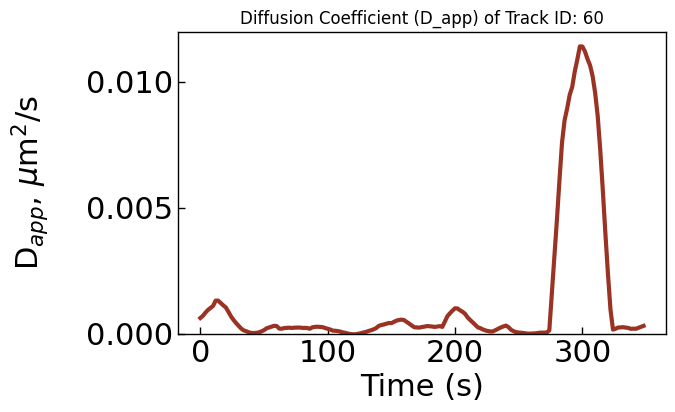

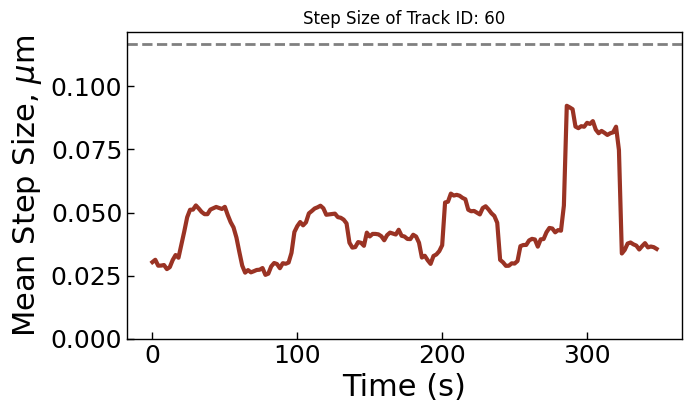

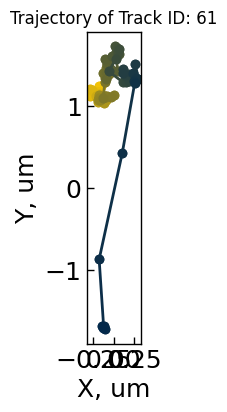

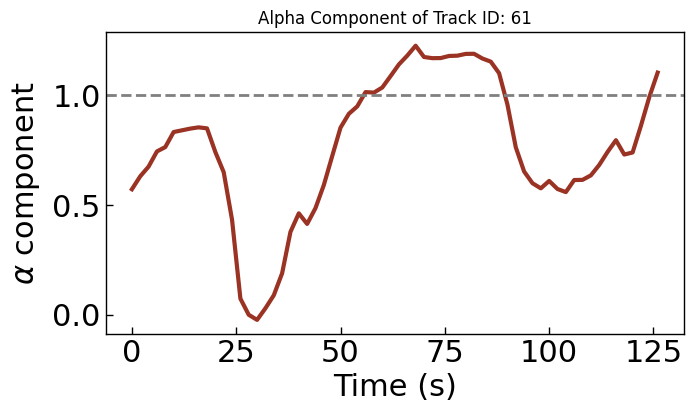

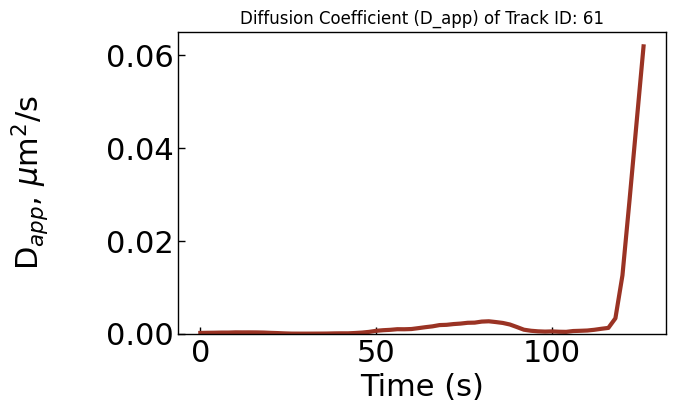

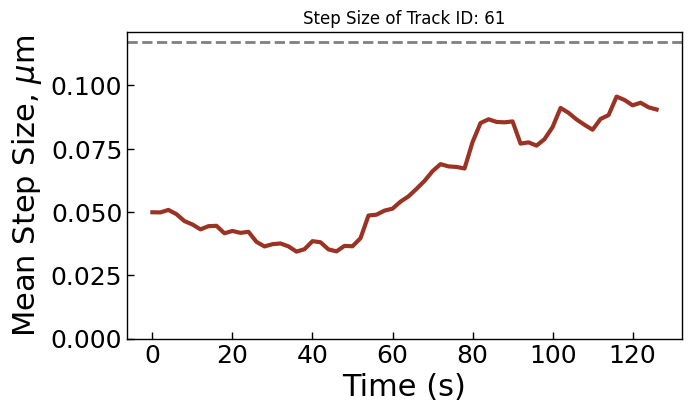

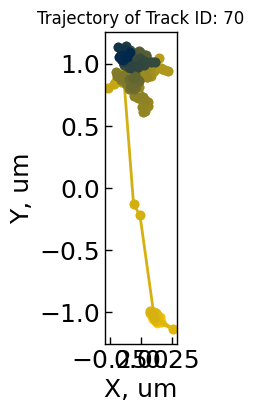

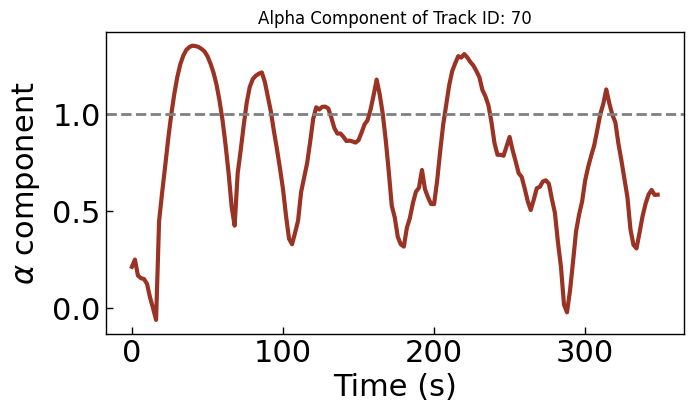

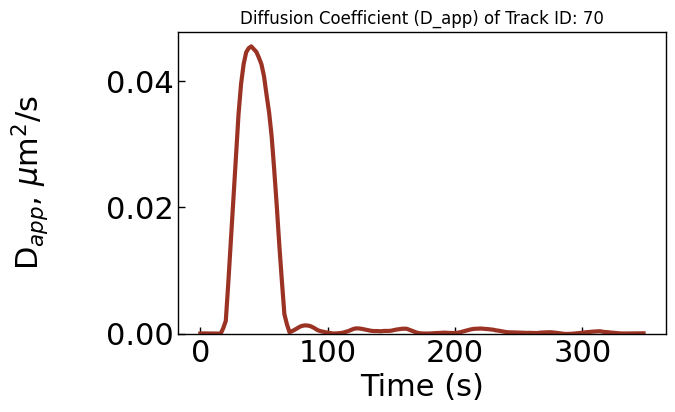

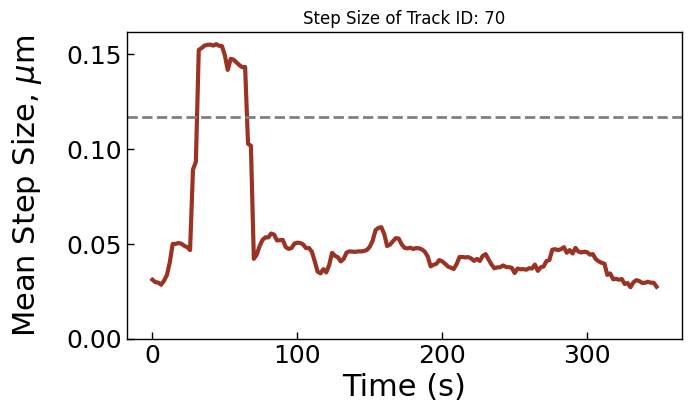

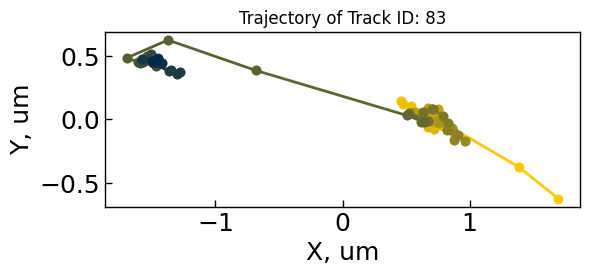

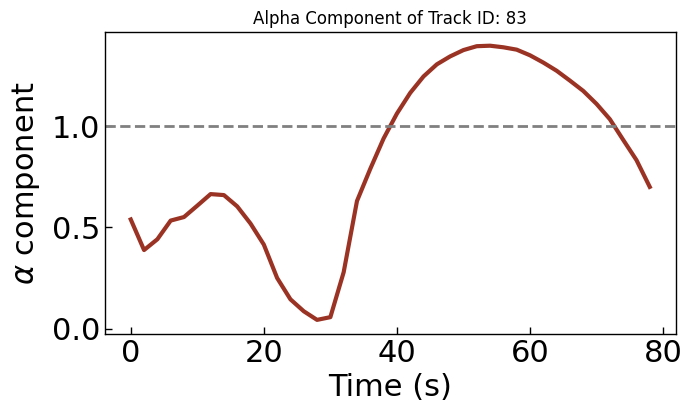

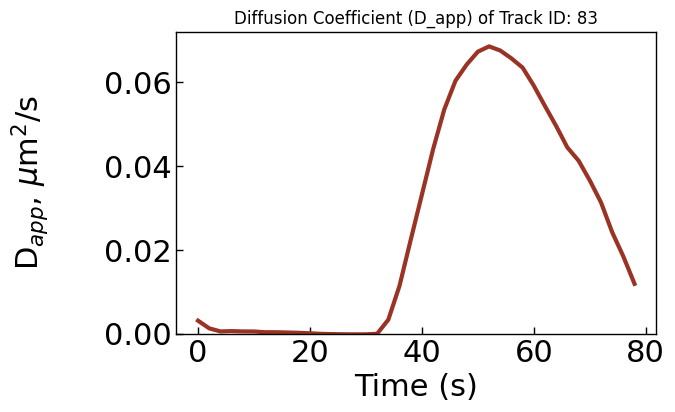

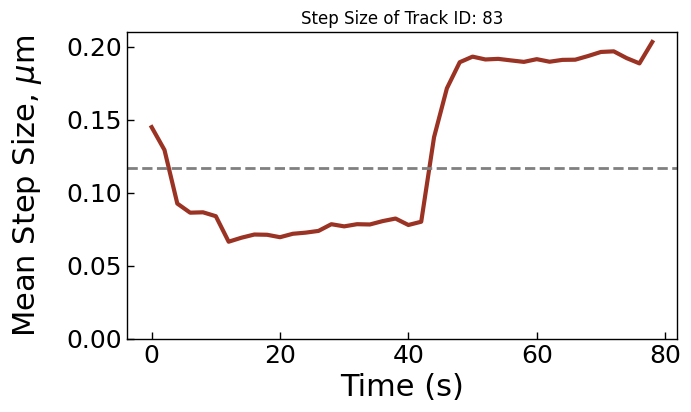

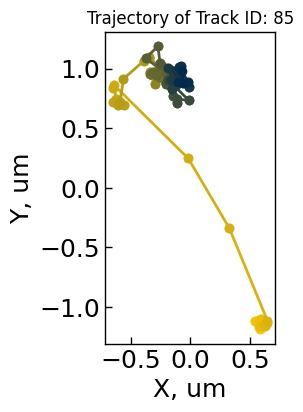

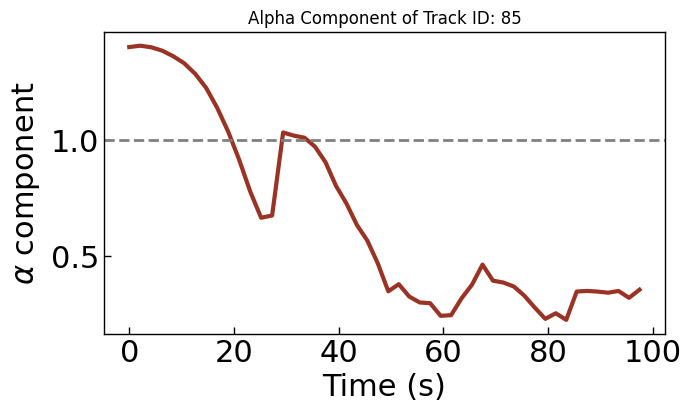

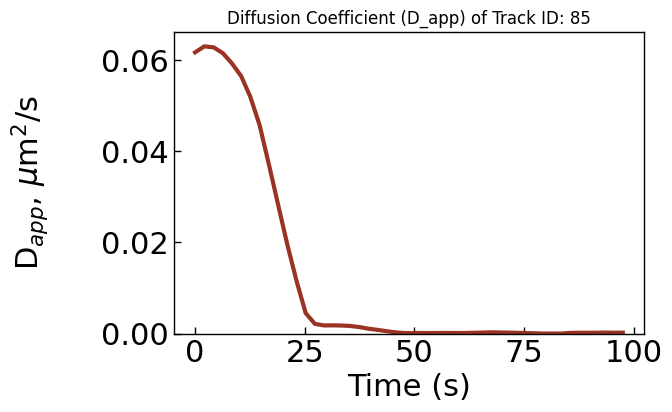

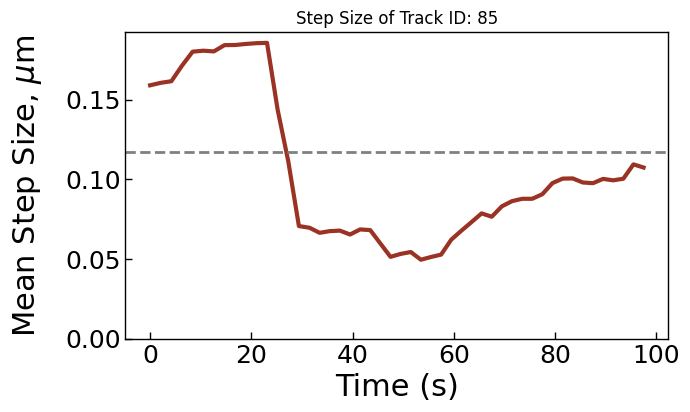

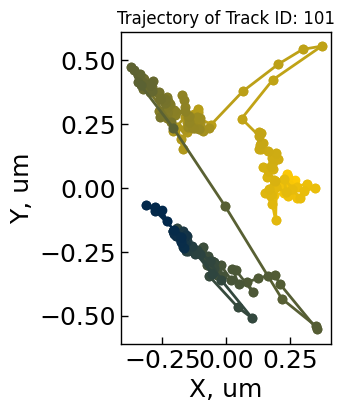

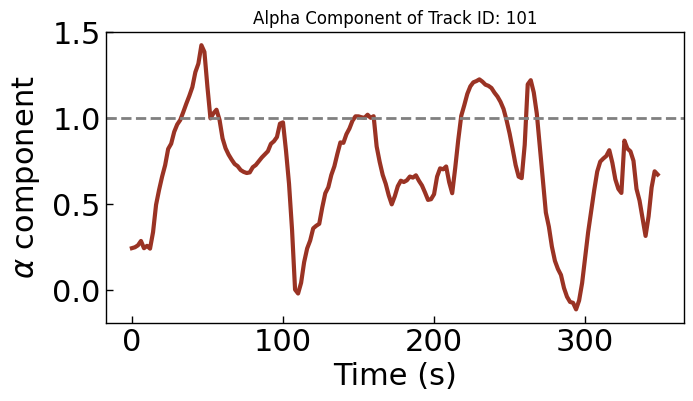

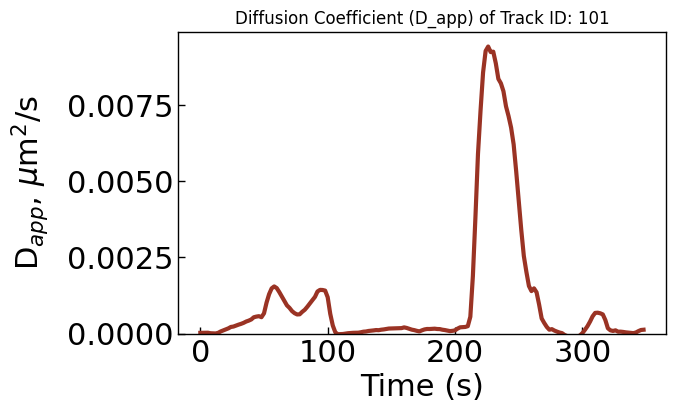

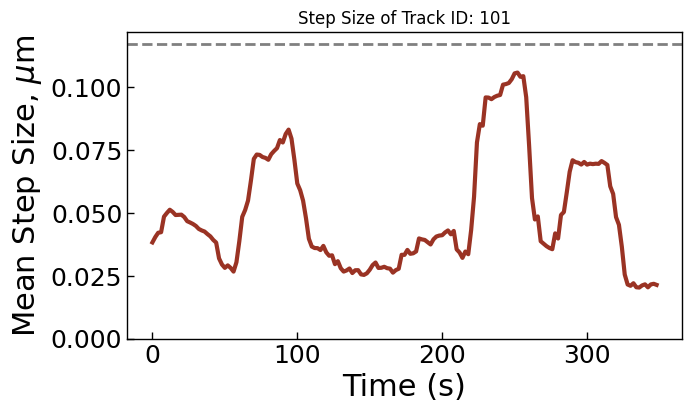

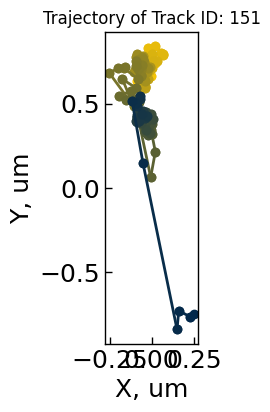

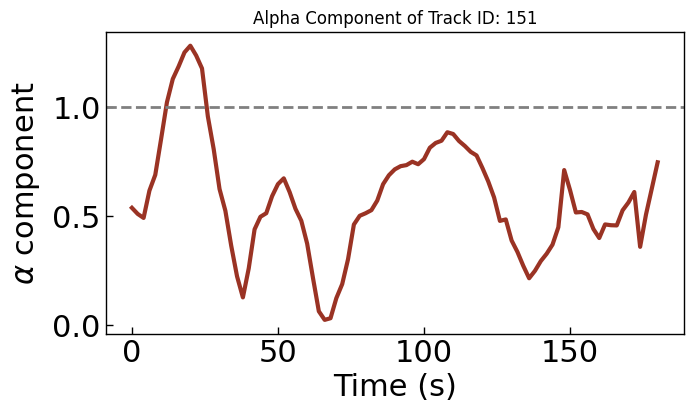

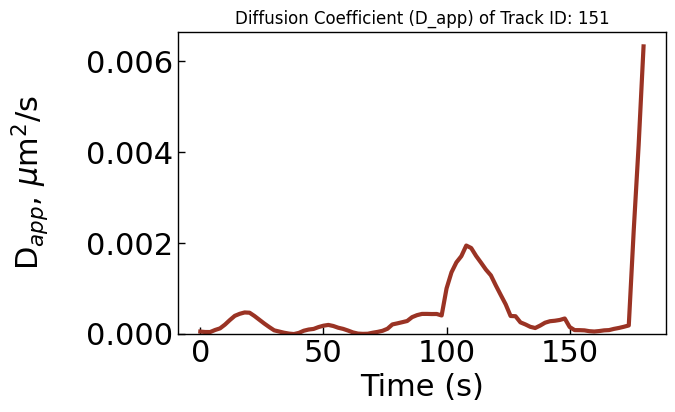

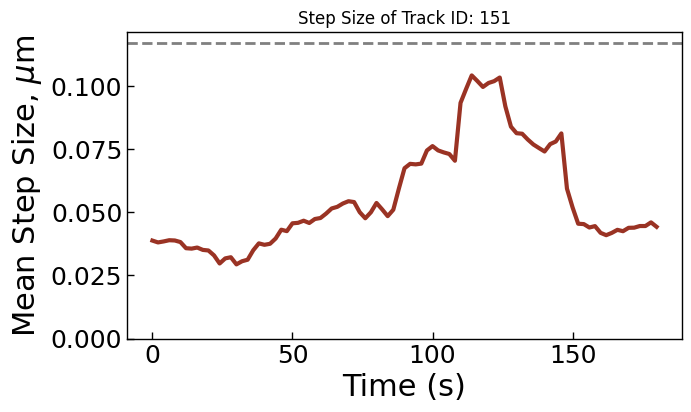

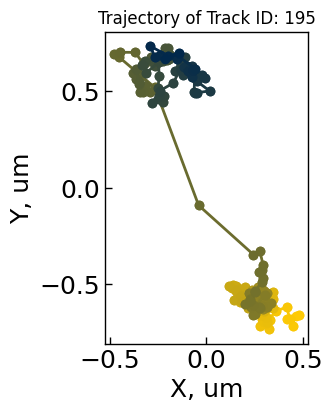

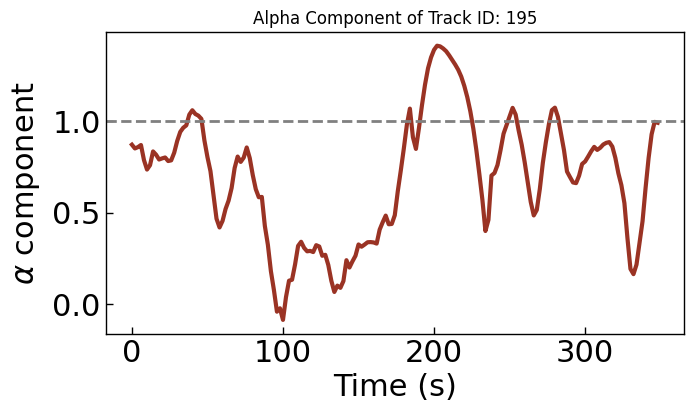

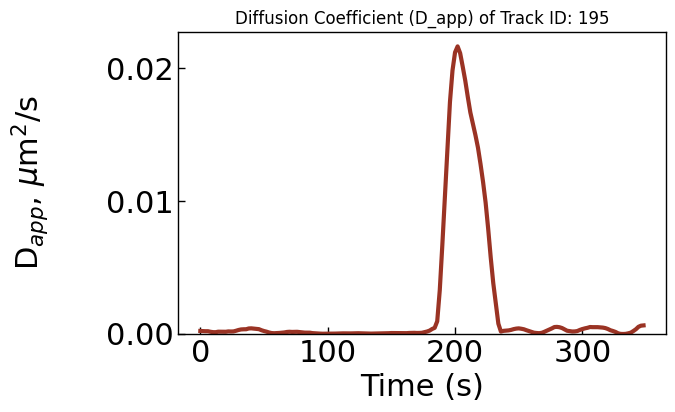

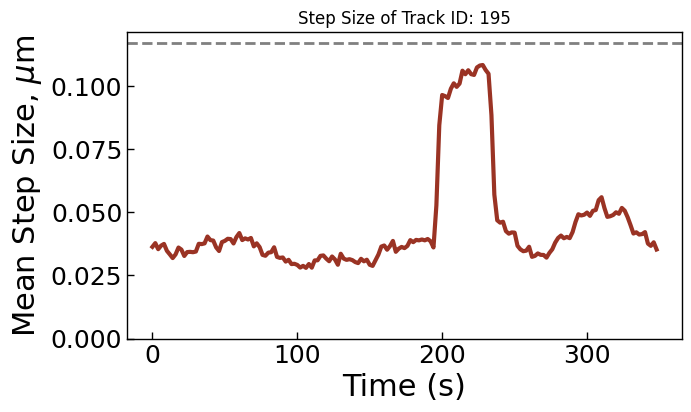

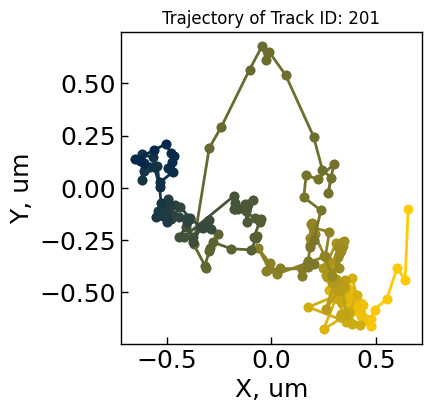

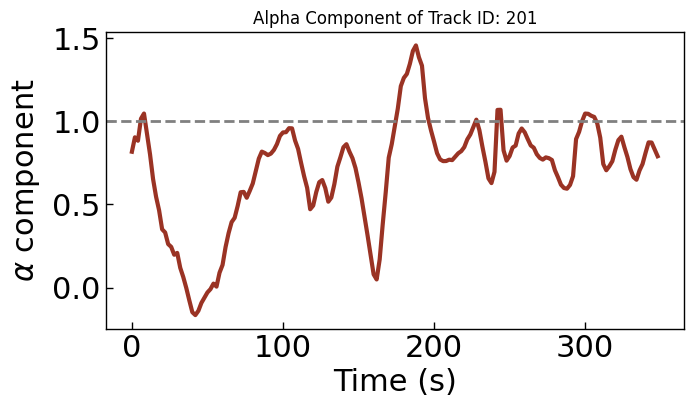

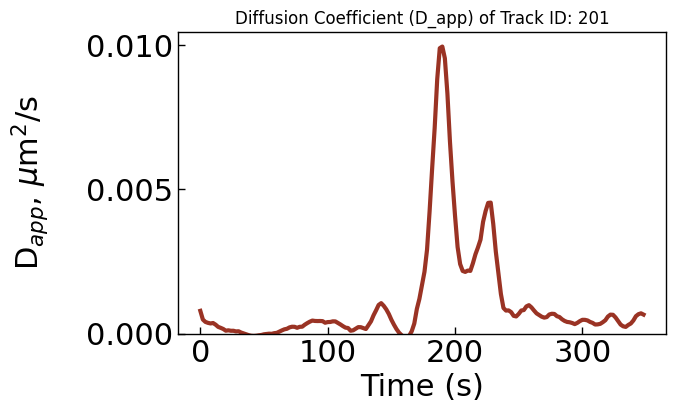

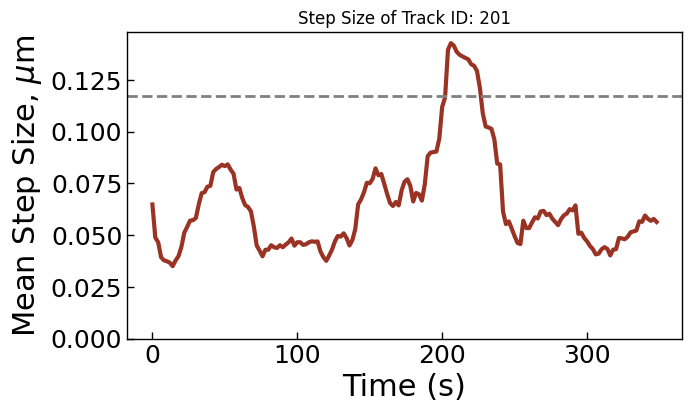

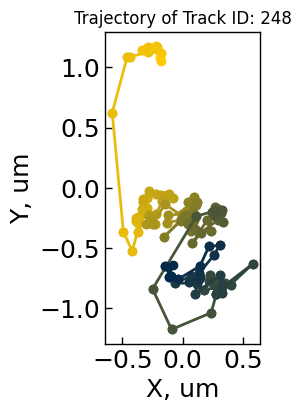

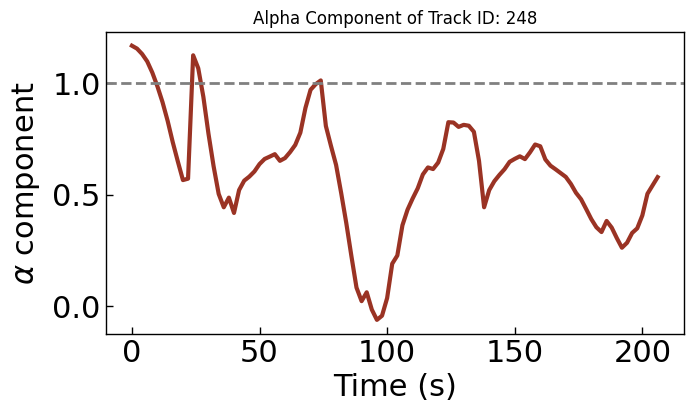

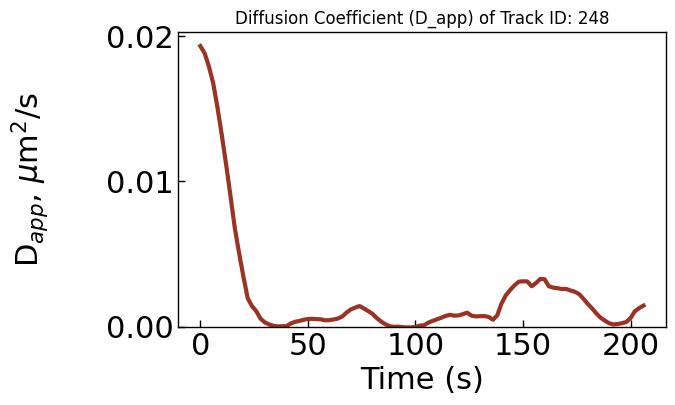

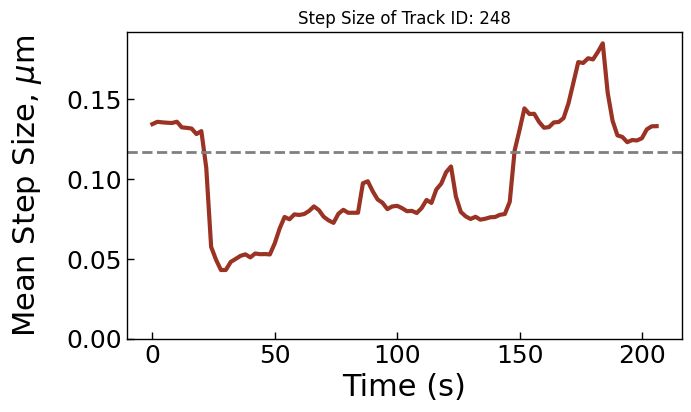

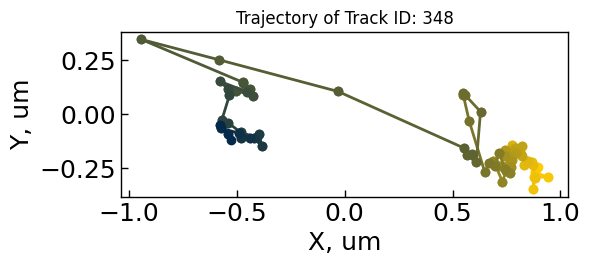

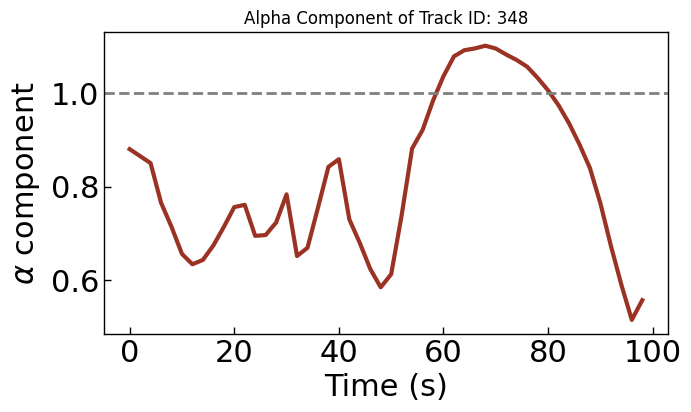

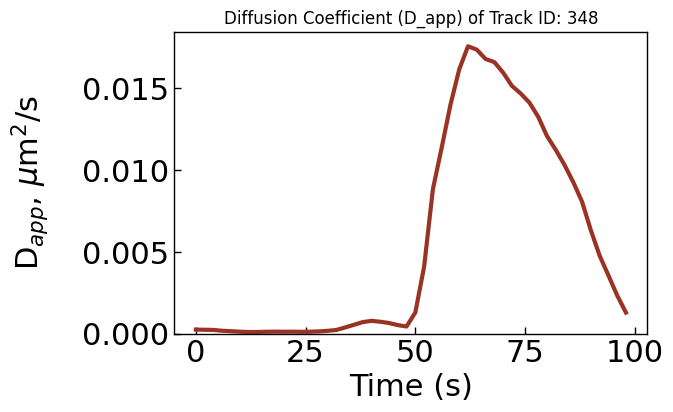

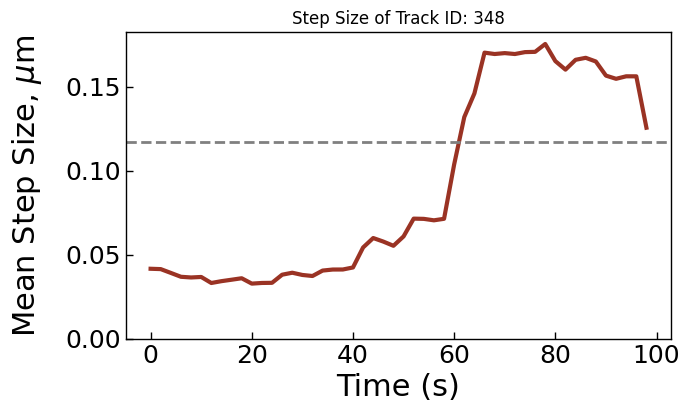

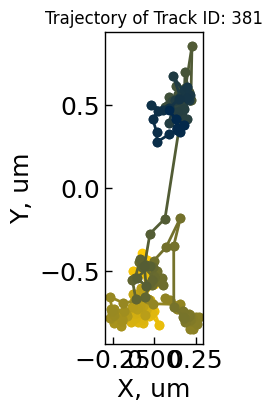

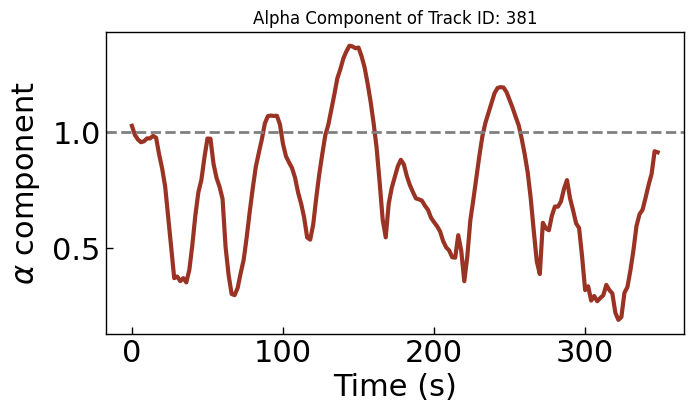

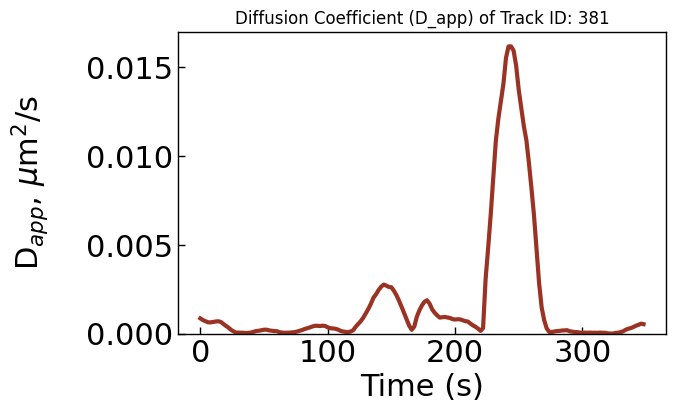

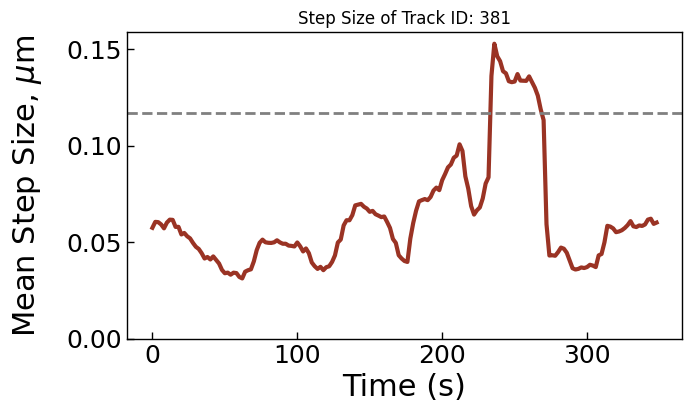

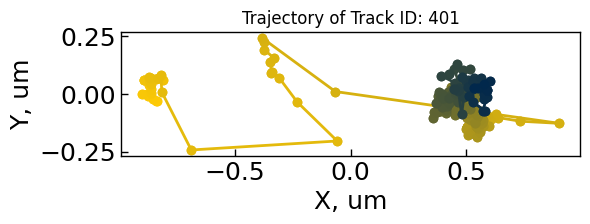

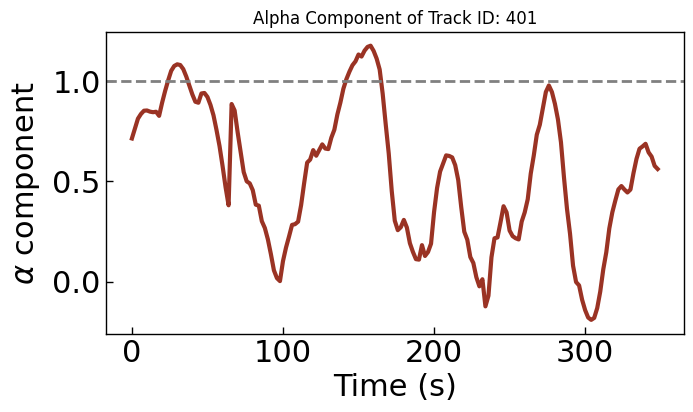

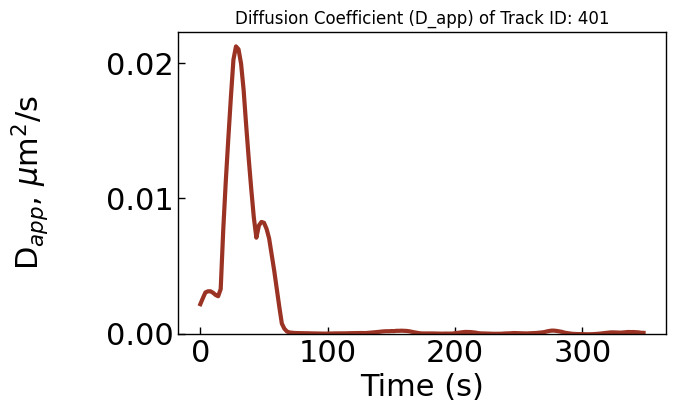

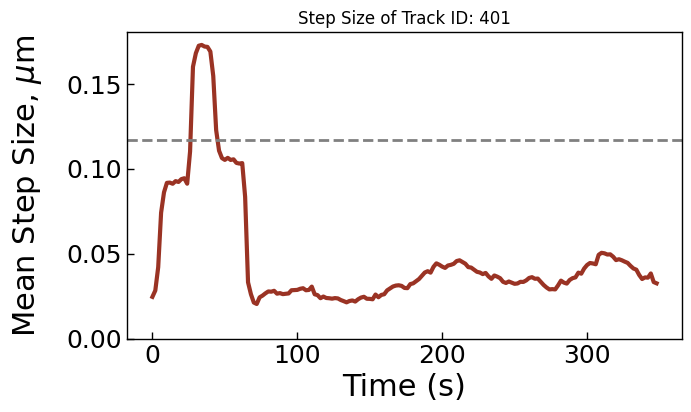

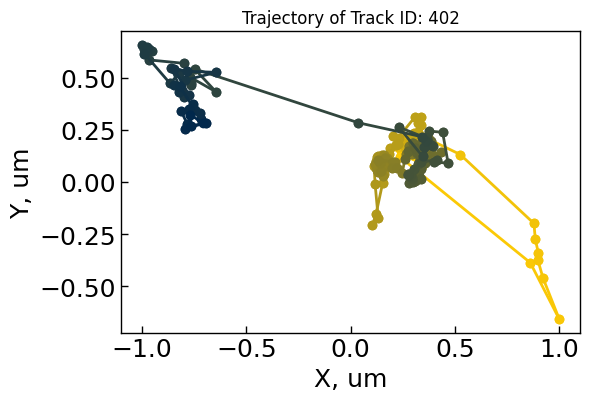

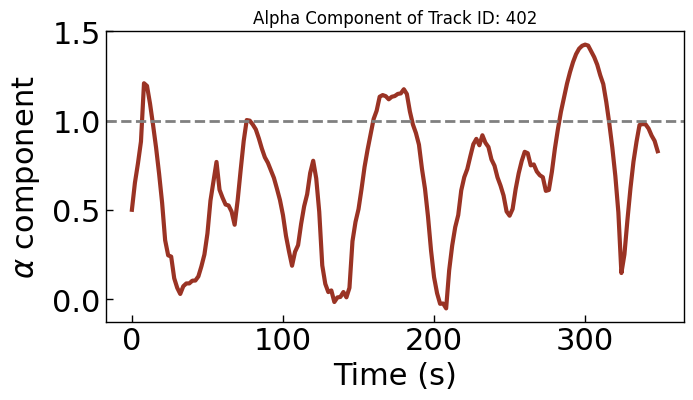

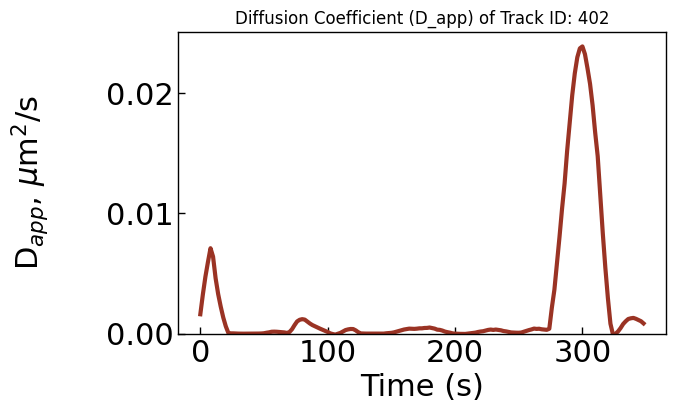

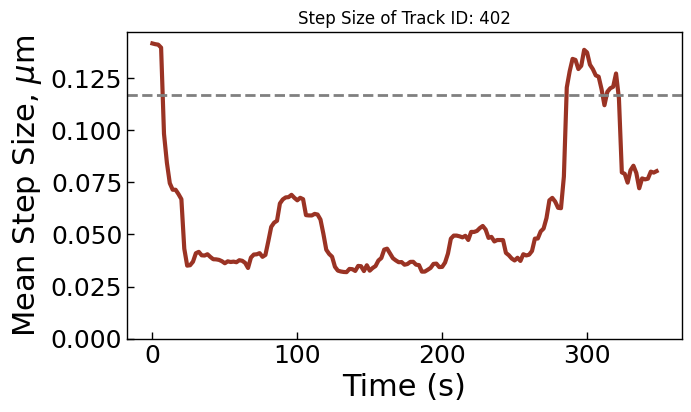

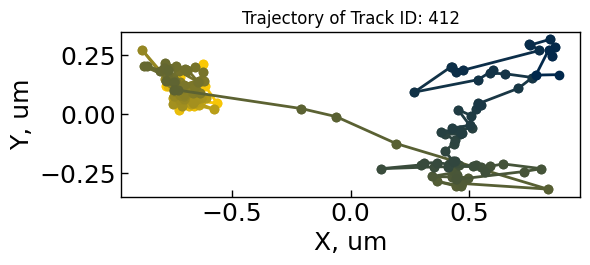

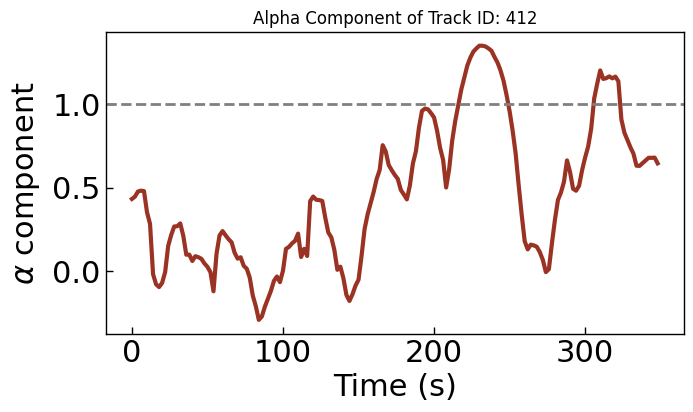

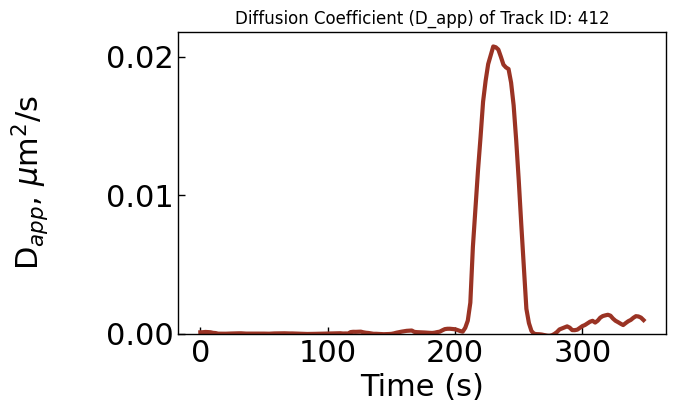

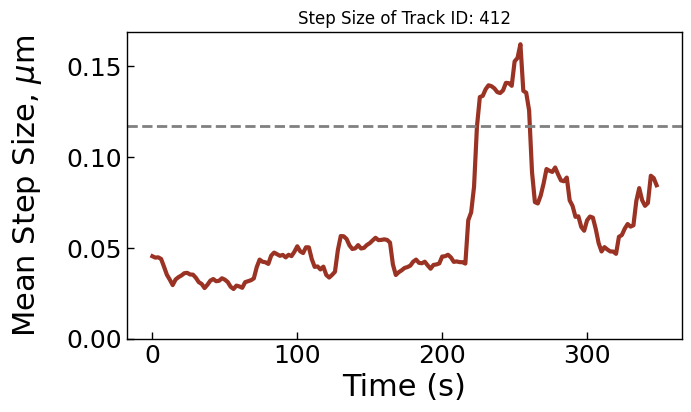

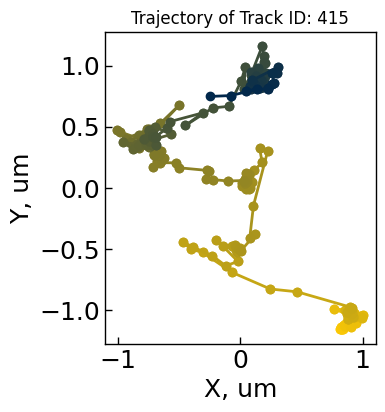

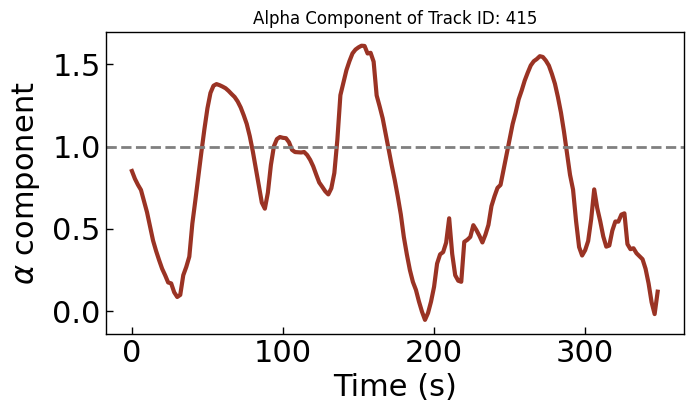

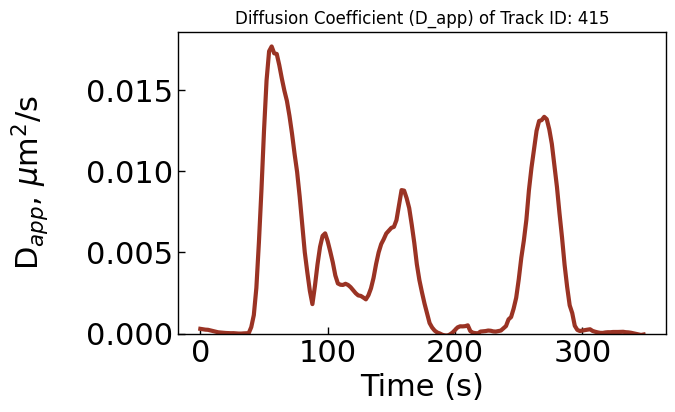

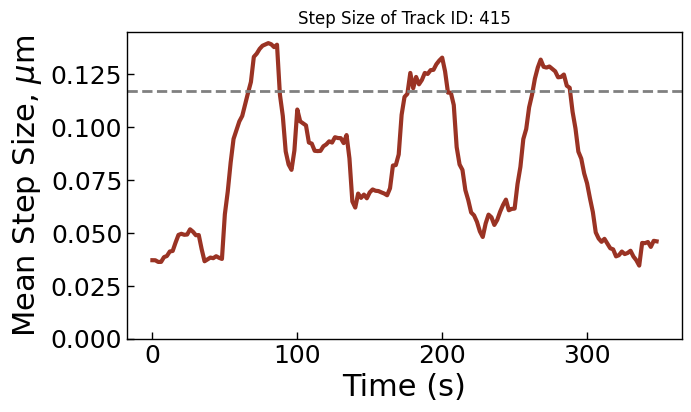

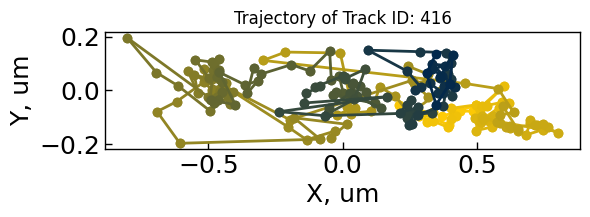

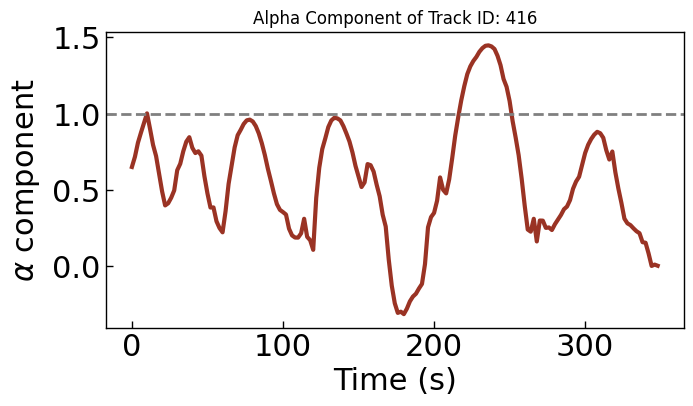

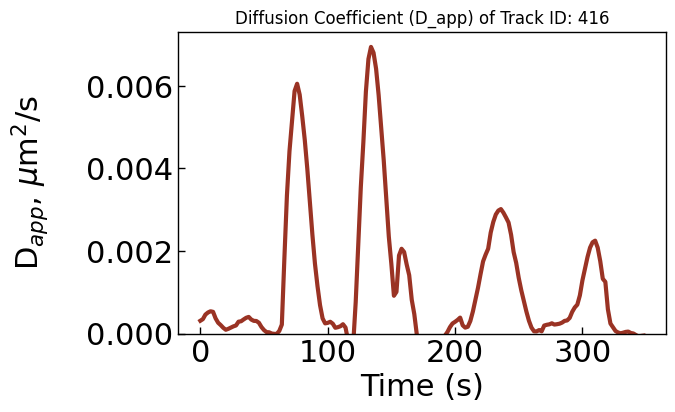

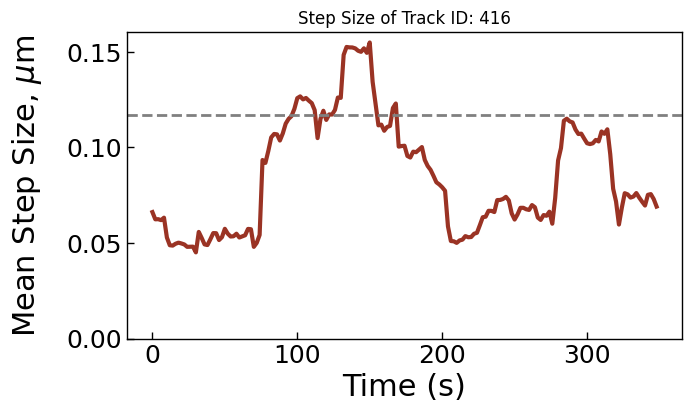

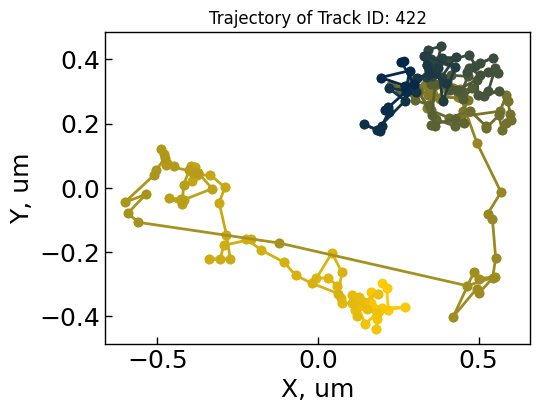

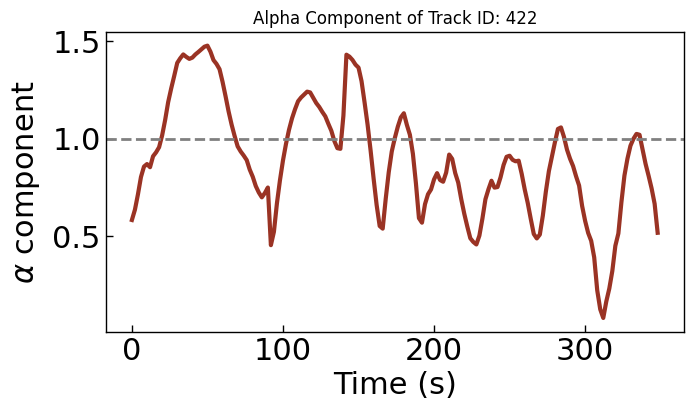

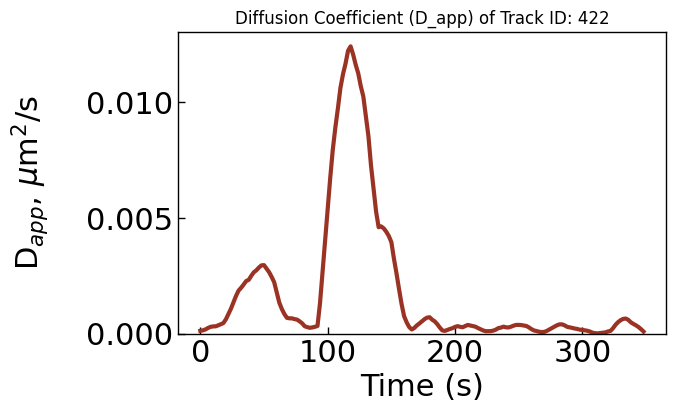

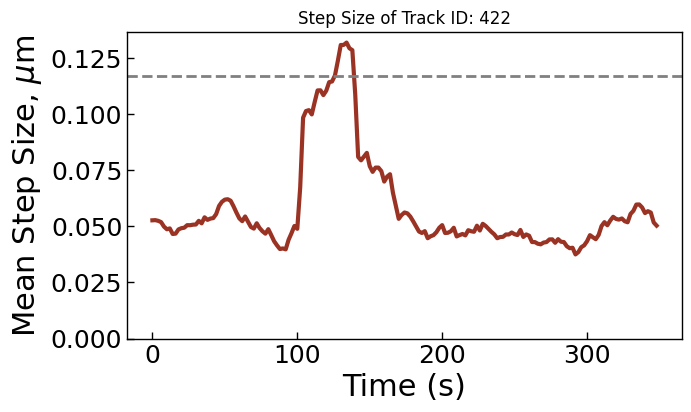

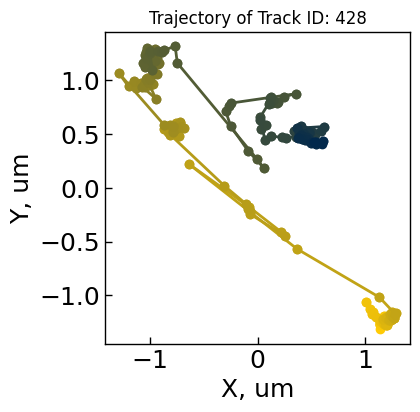

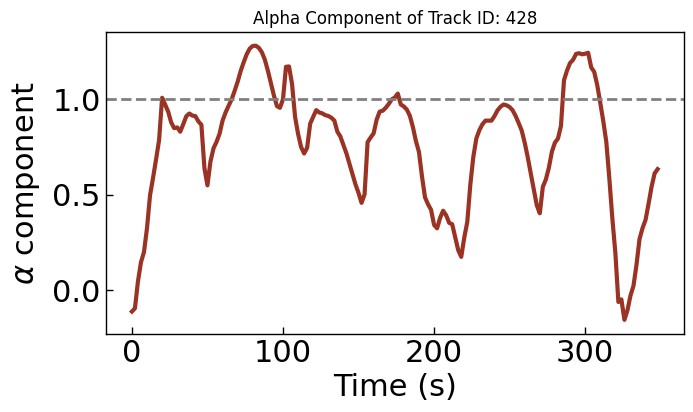

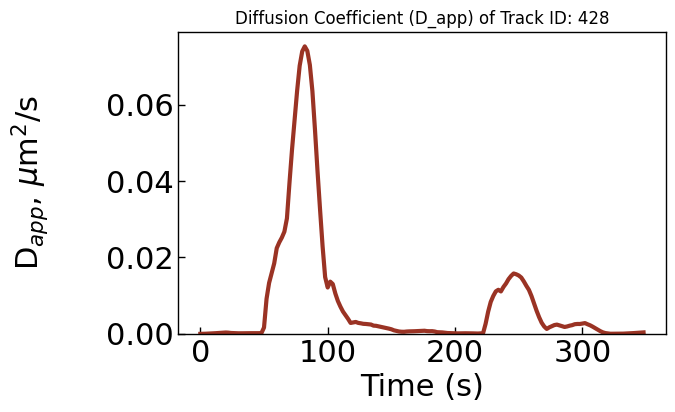

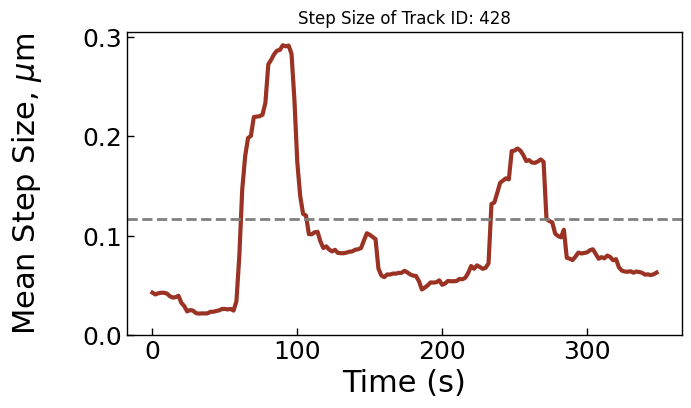

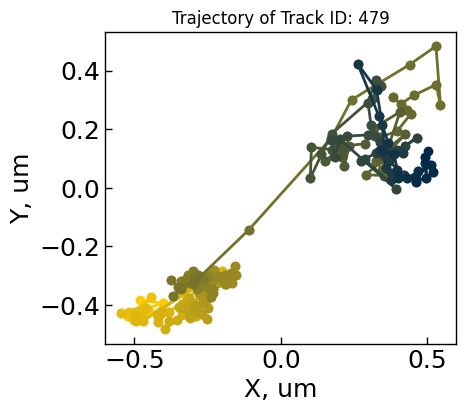

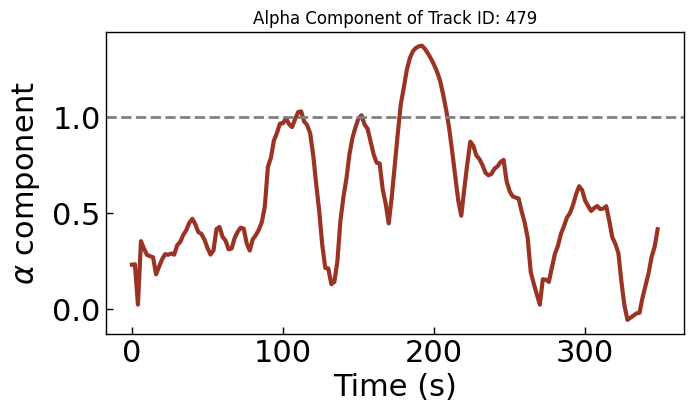

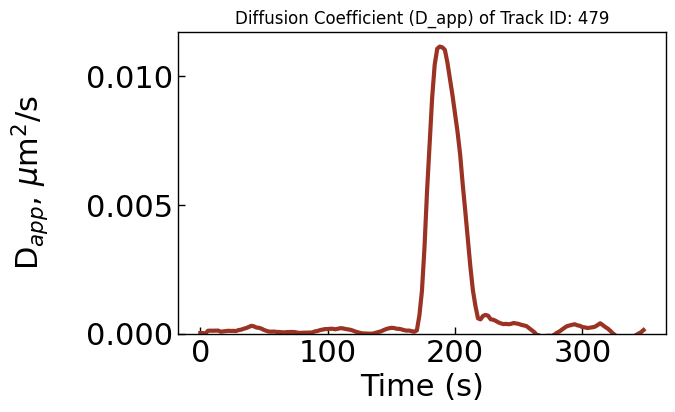

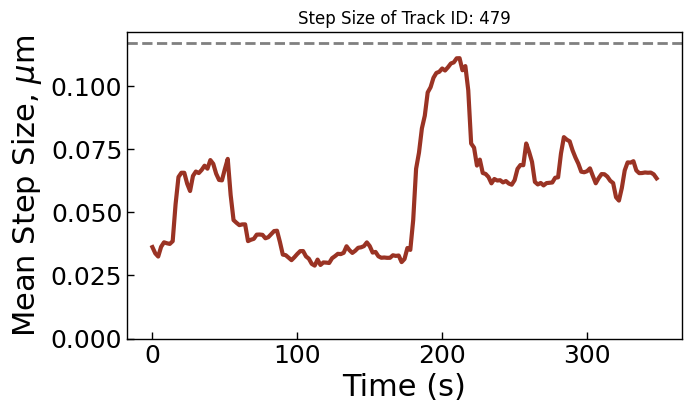

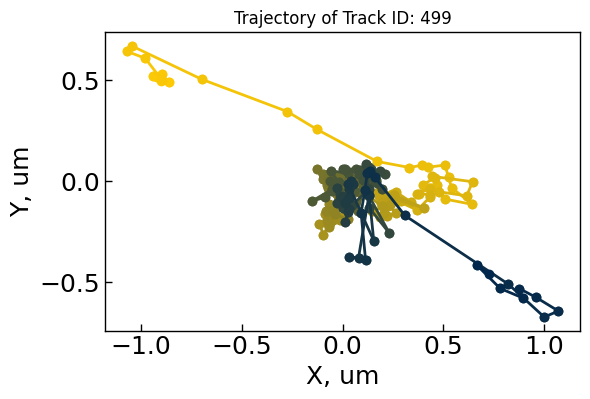

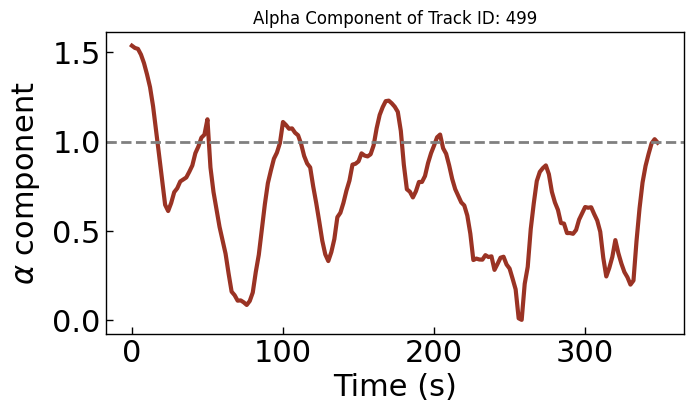

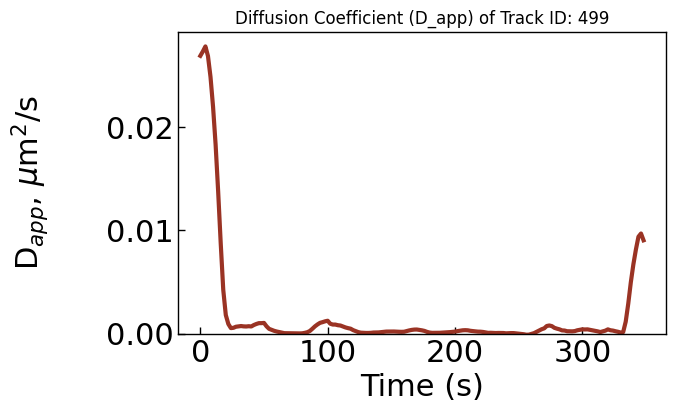

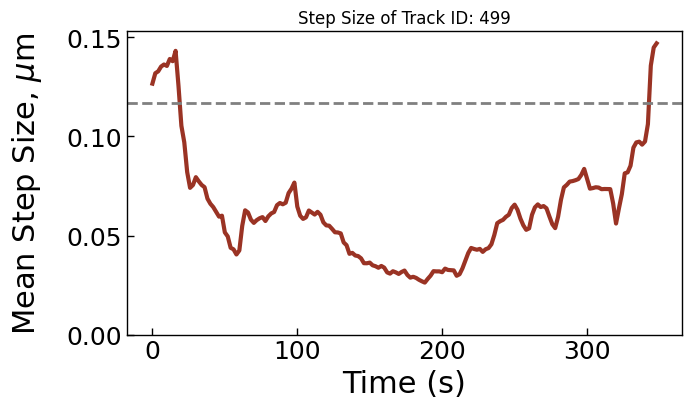

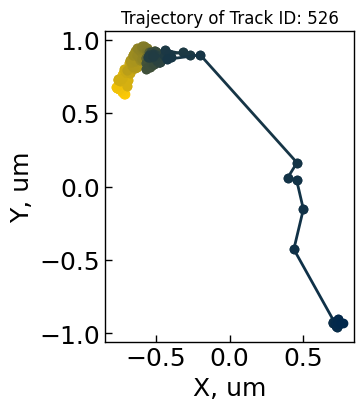

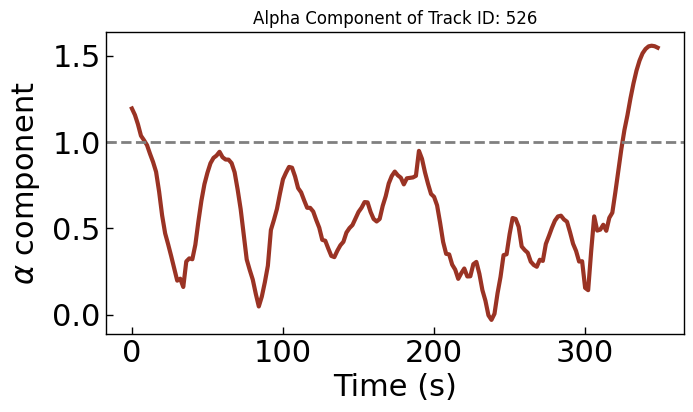

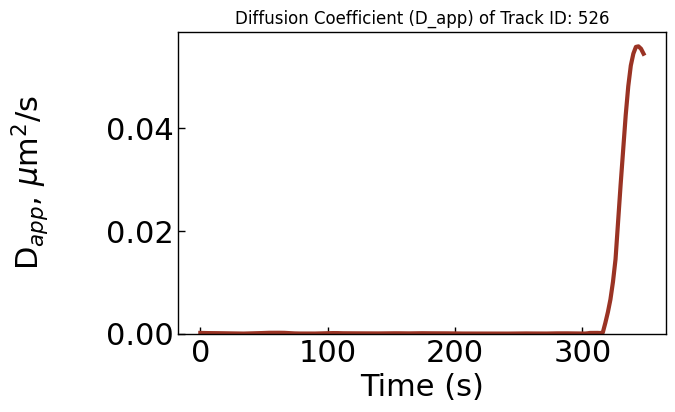

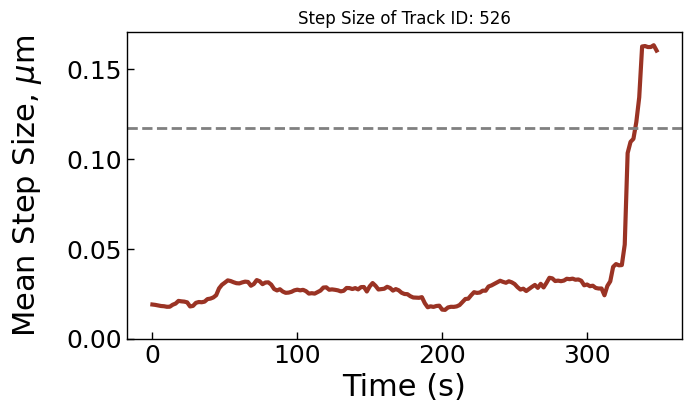

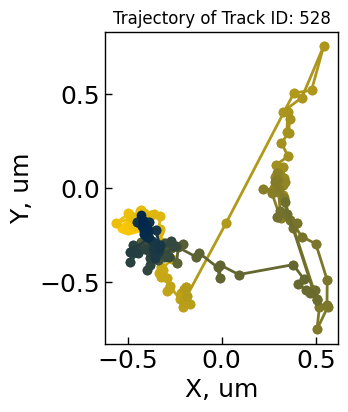

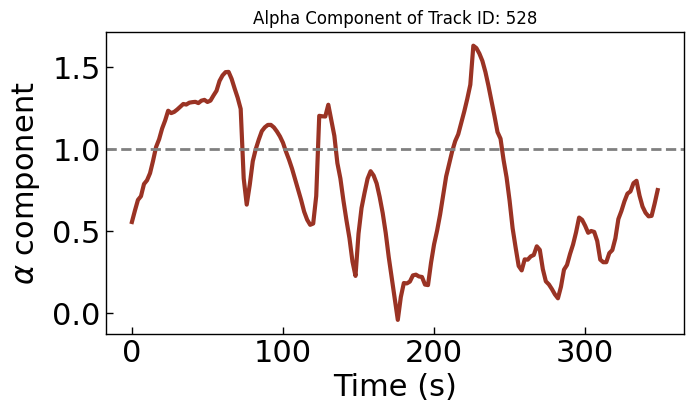

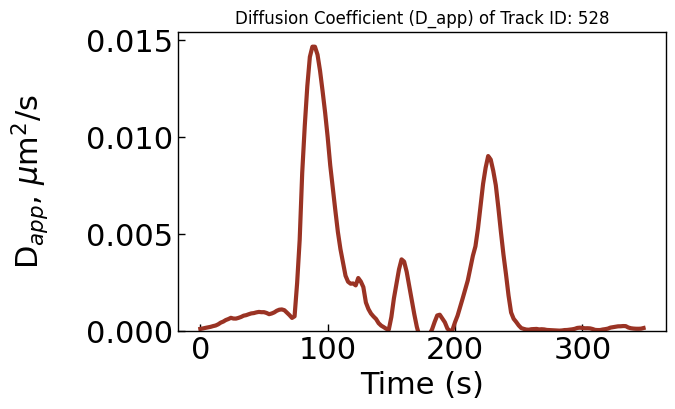

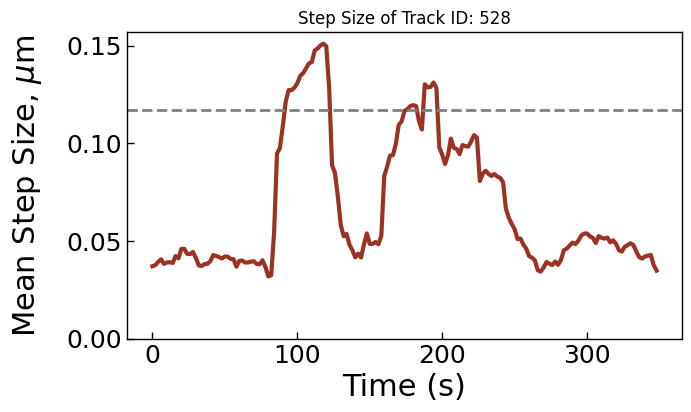

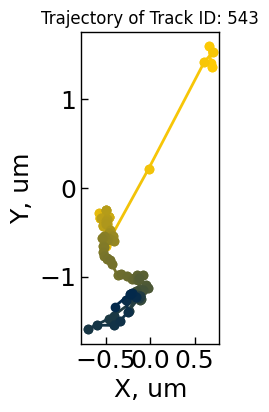

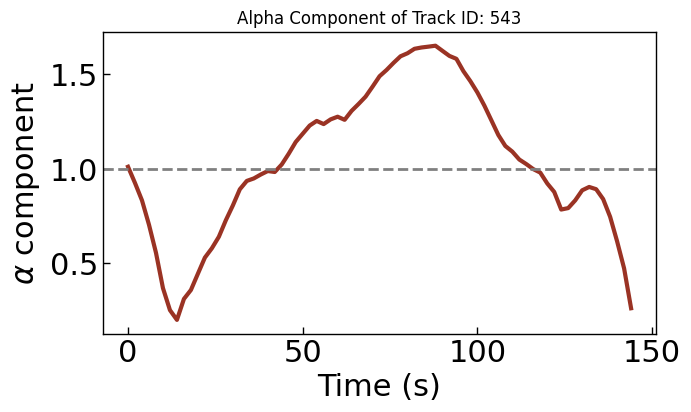

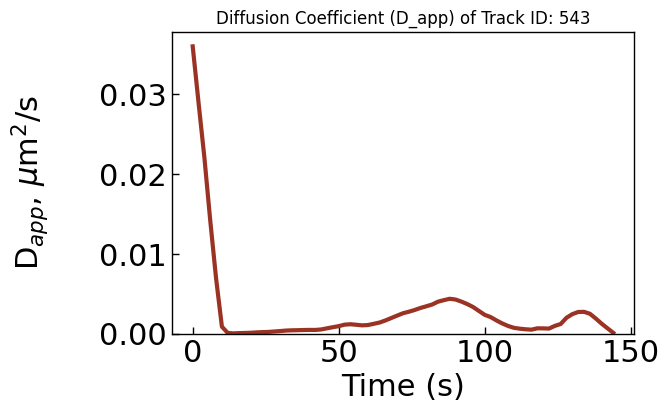

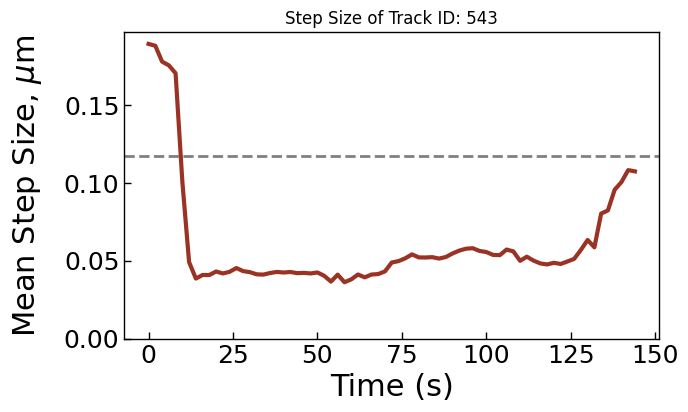

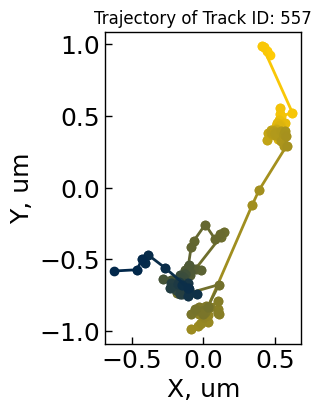

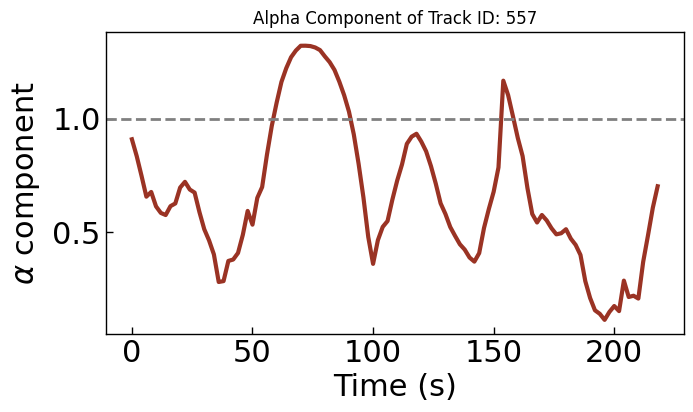

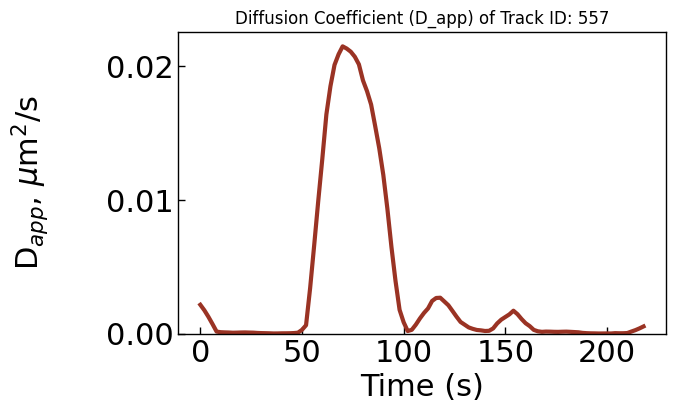

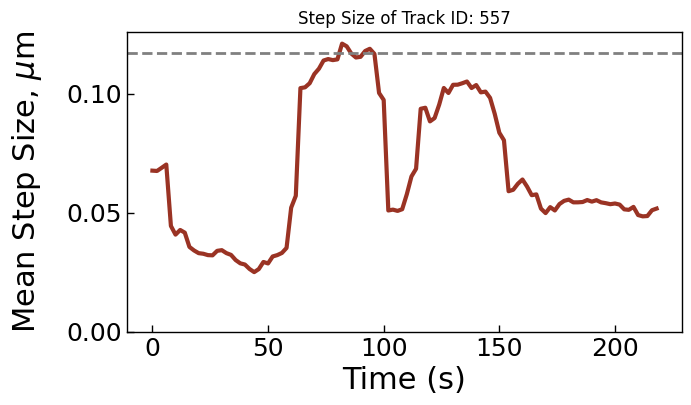

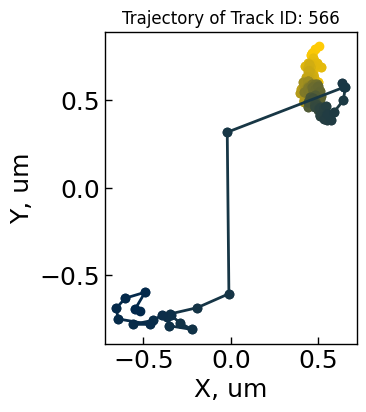

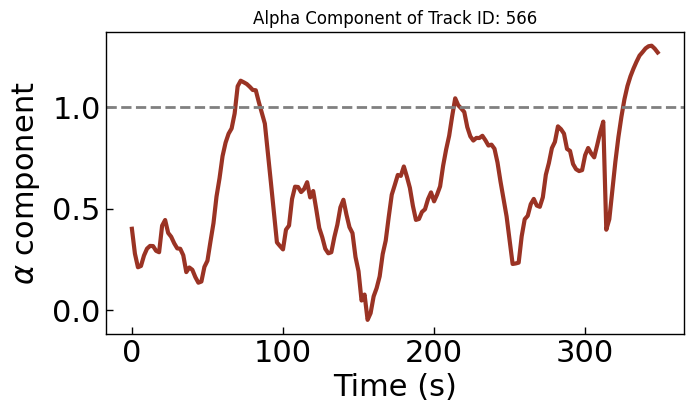

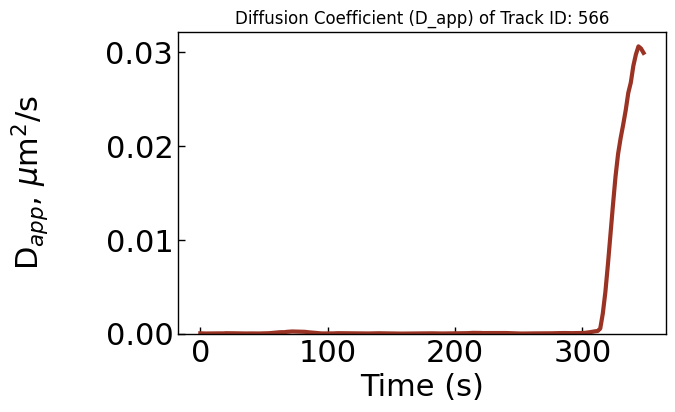

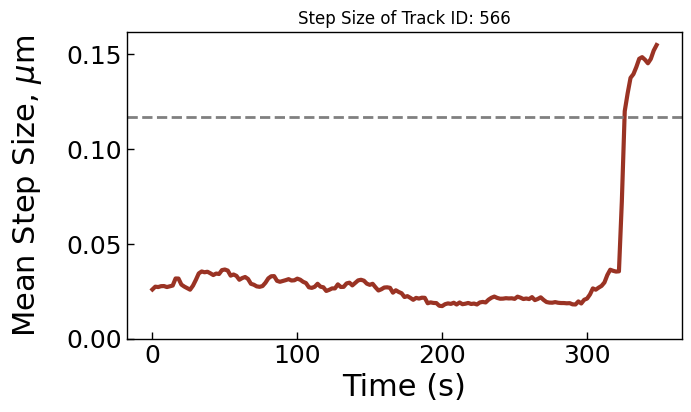

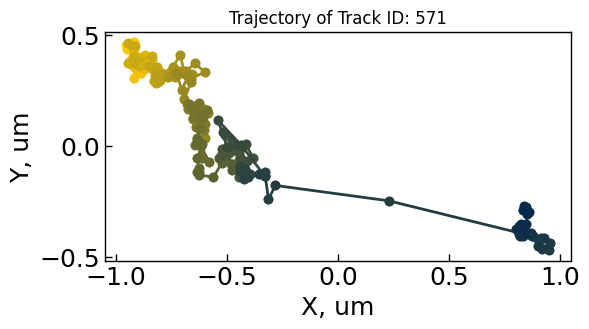

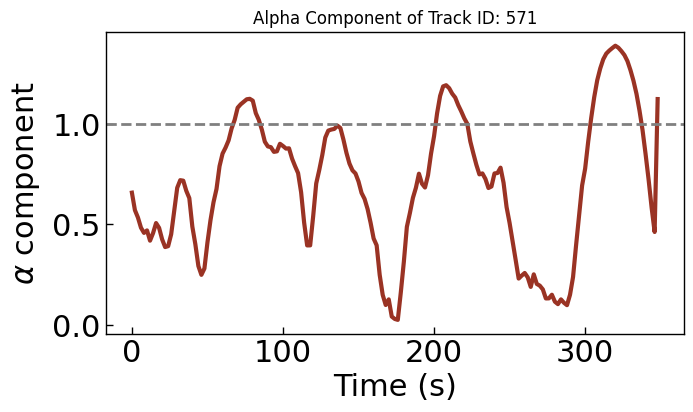

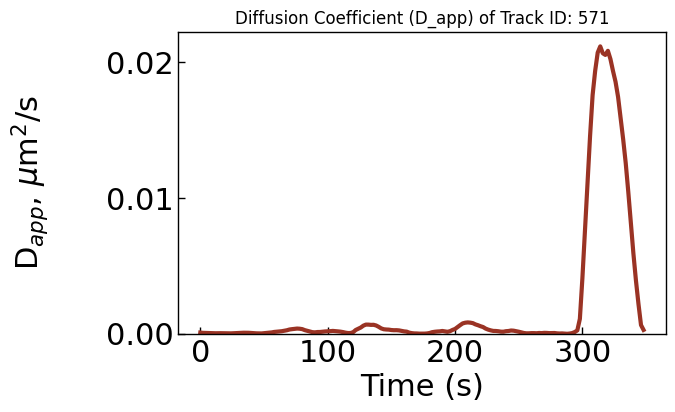

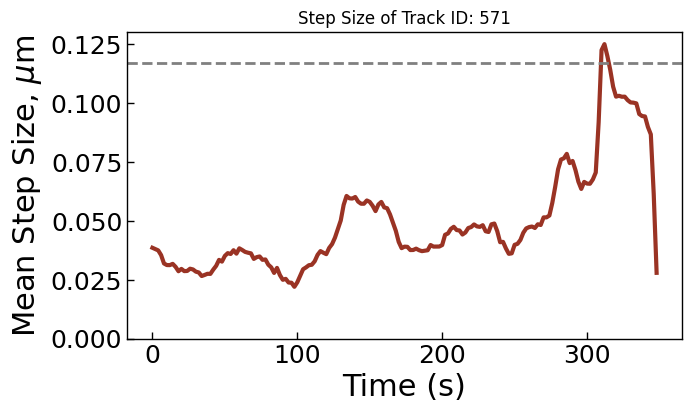

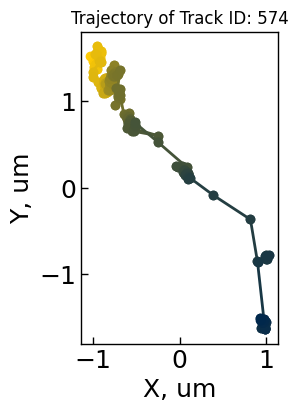

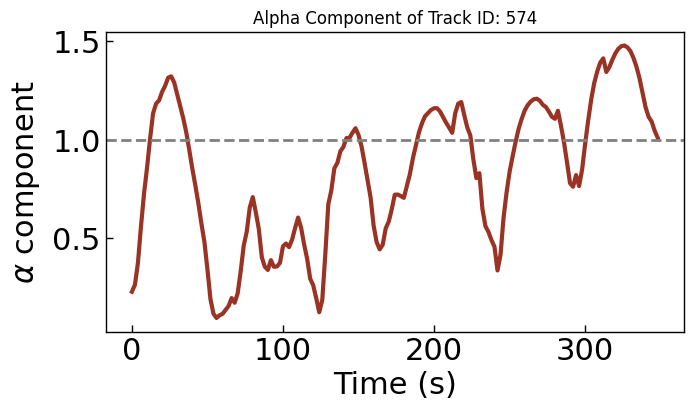

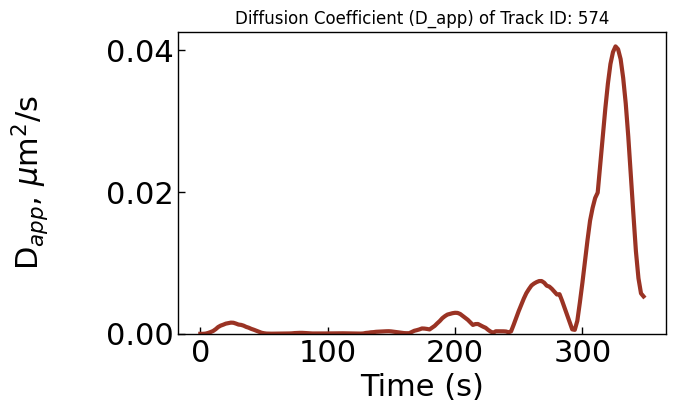

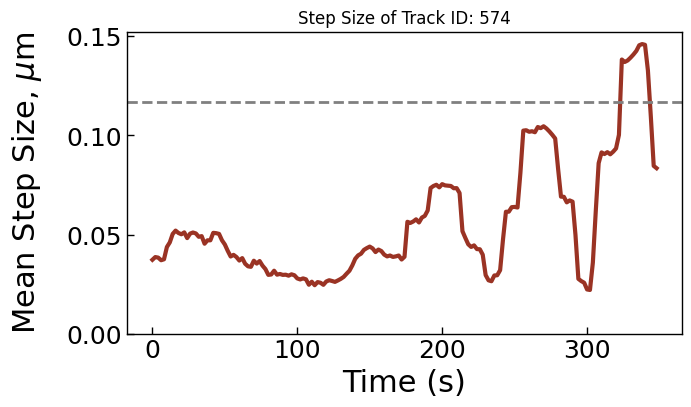

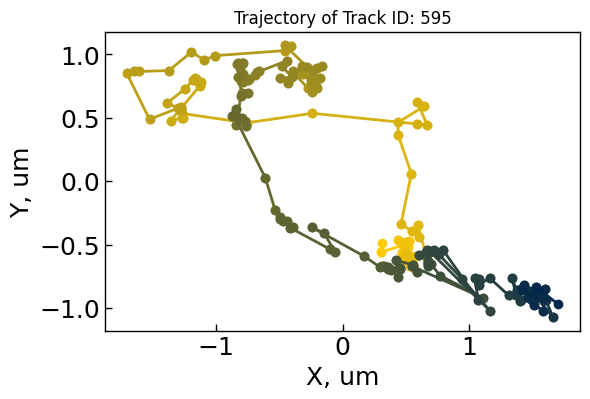

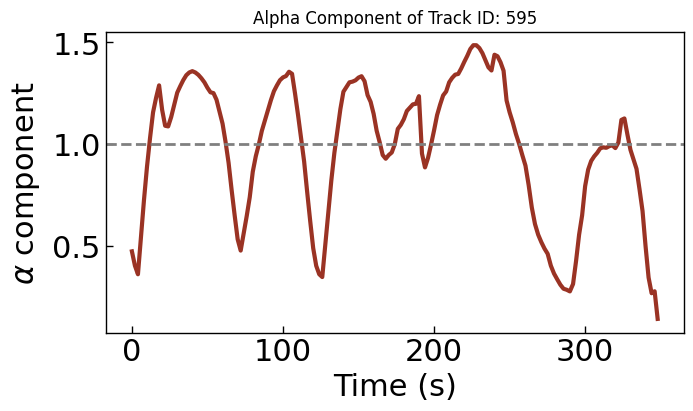

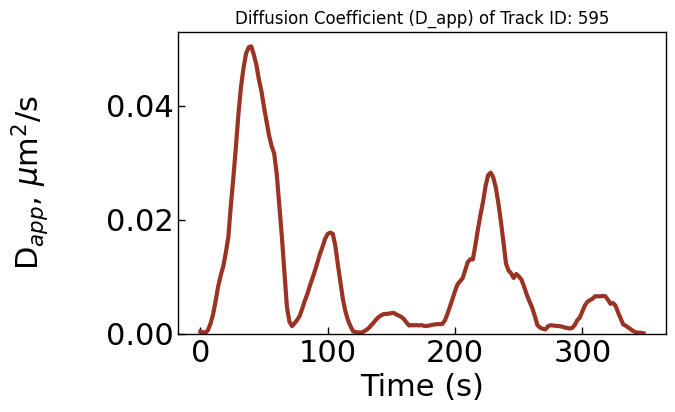

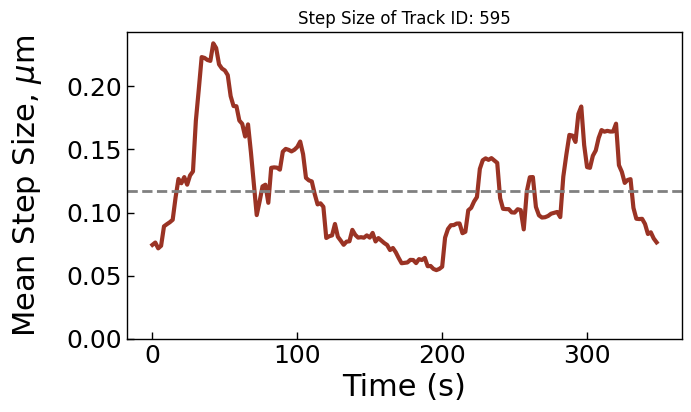

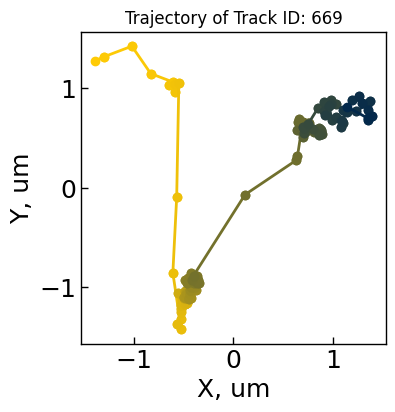

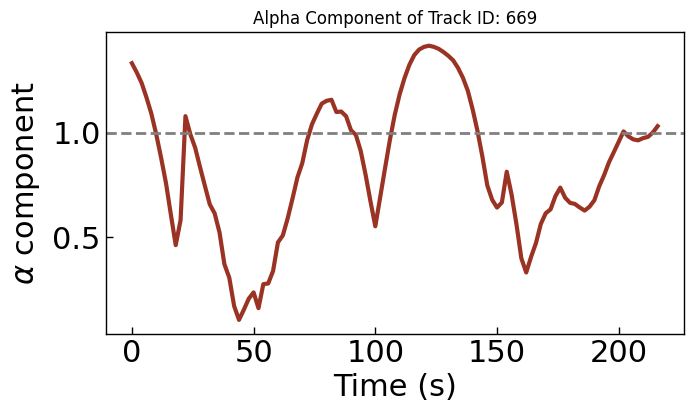

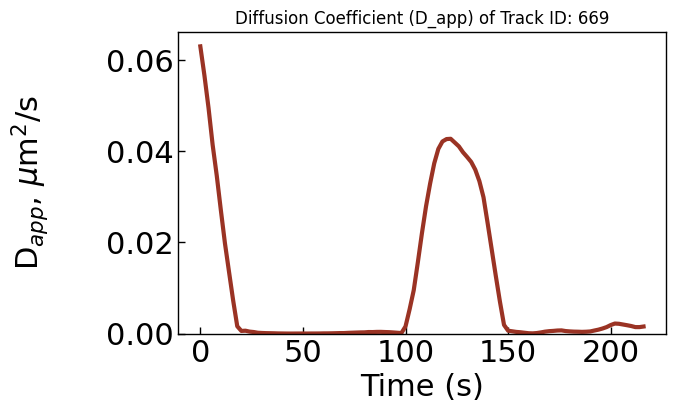

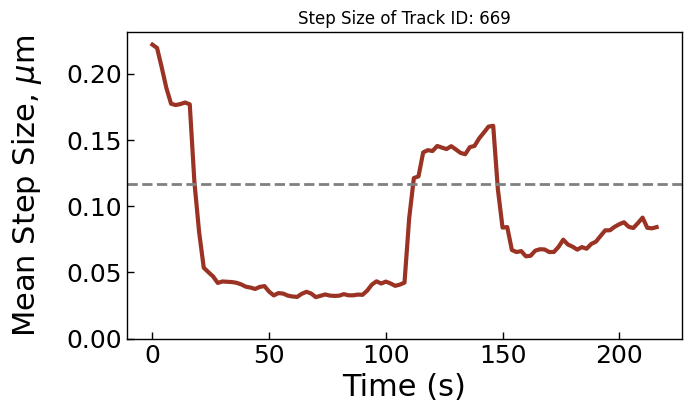

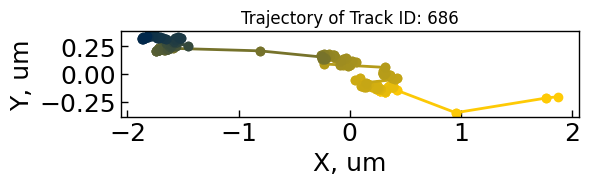

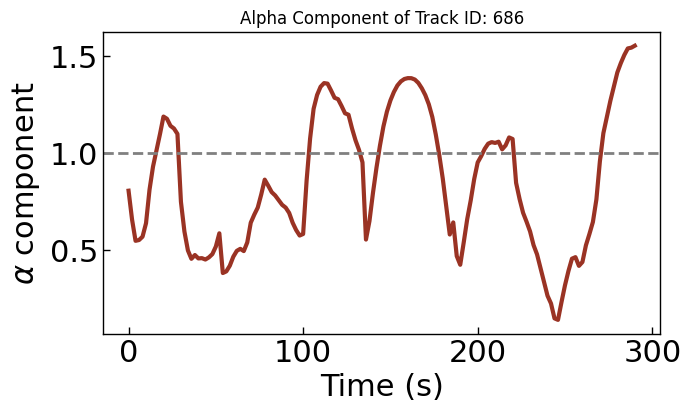

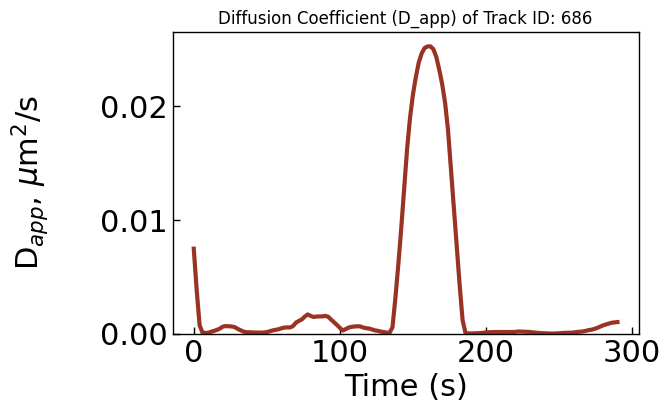

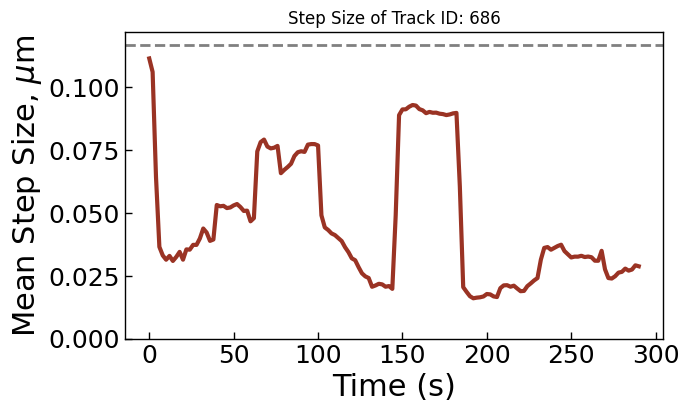

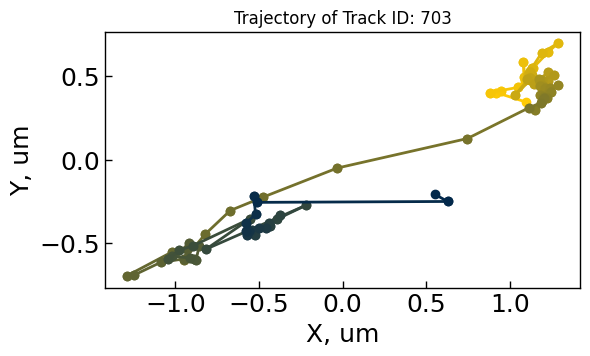

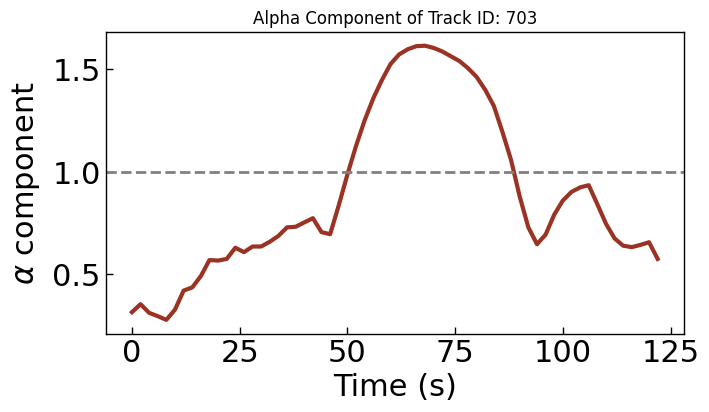

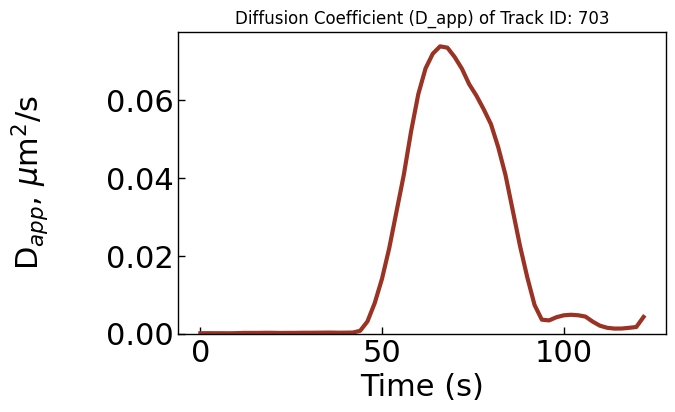

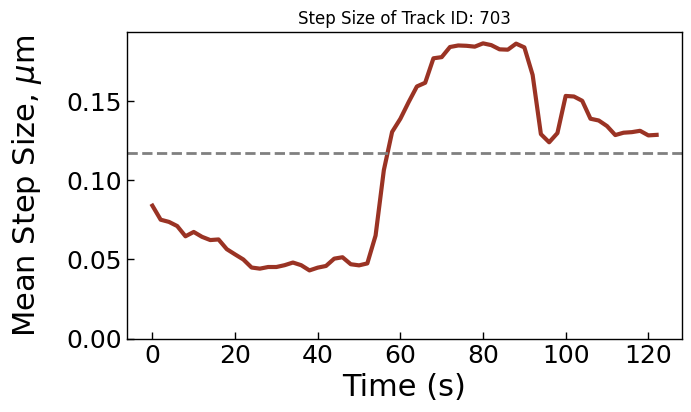

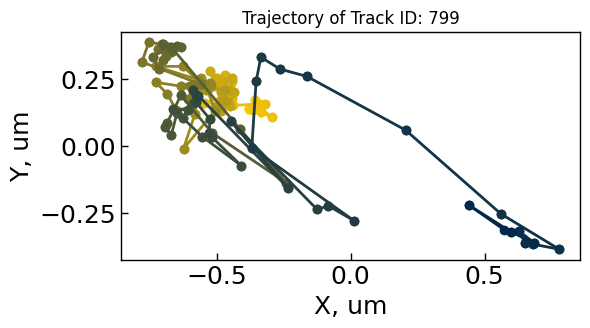

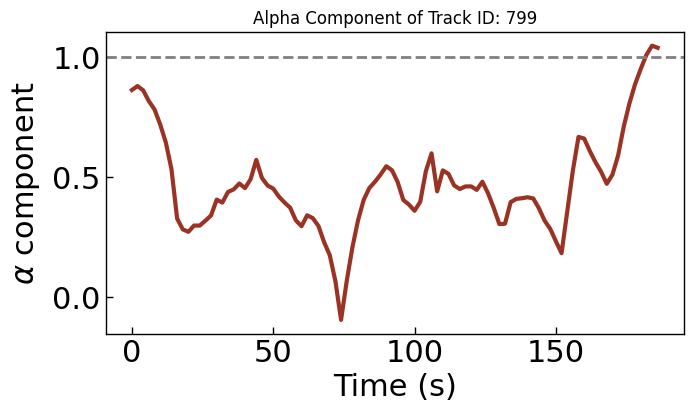

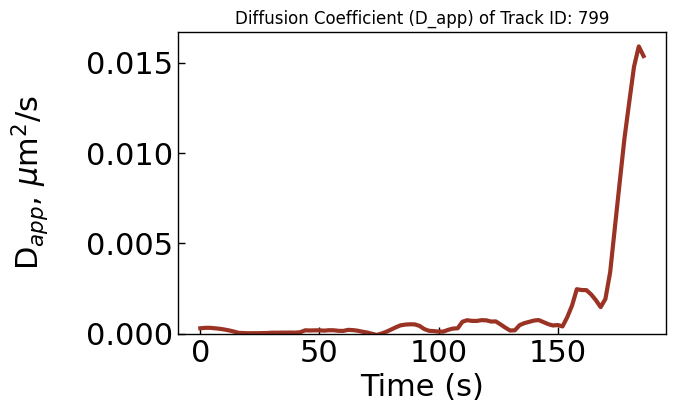

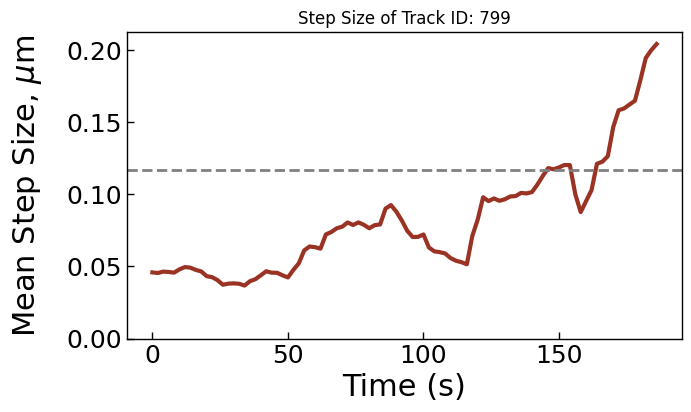

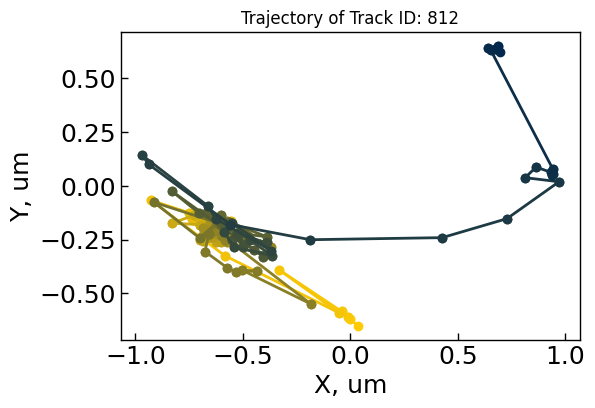

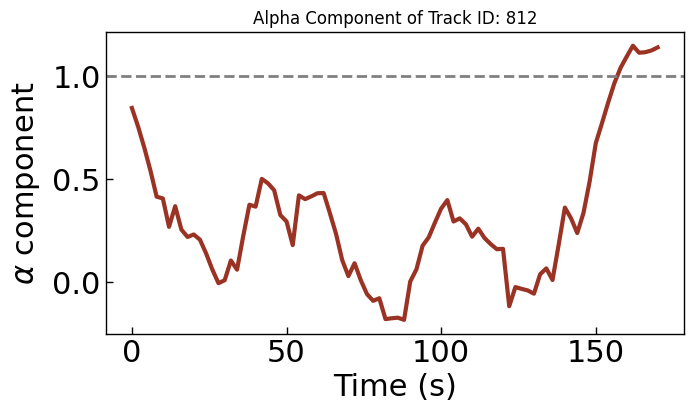

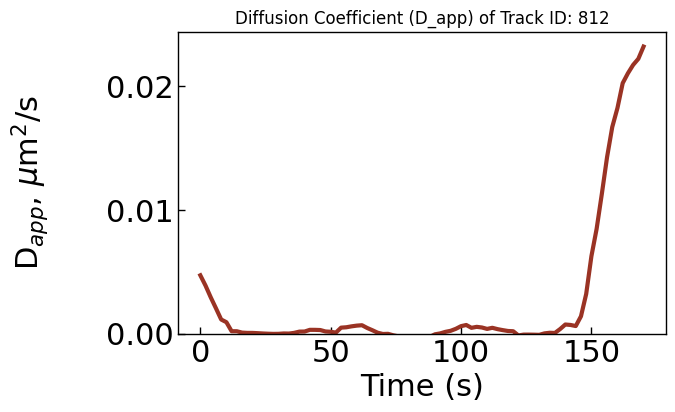

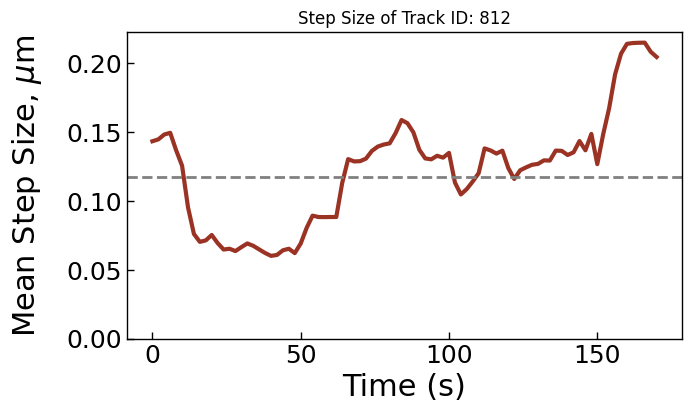

In [8]:
# Process each track separately
for idx, track_id in enumerate(valid_track_ids):
    track_data = data[data['trackID'] == track_id].copy()
    track_data['x'] = track_data['x'] * um_per_pixel
    track_data['y'] = track_data['y'] * um_per_pixel
    track_data['t'] = track_data['t'] * s_per_frame
    
    # Plot the trajectory
    fig, ax = plt.subplots(figsize=(6, 4))
    x = track_data['x'].values
    y = track_data['y'].values
    t = track_data['t'].values
    x_plot = x - (x.min() + x.max()) / 2
    y_plot = y - (y.min() + y.max()) / 2
    cmap_color_start = "#FFCB05"
    cmap_color_end = "#00274C"
    cmap_name = "maize2blue"
    cmap = clr.LinearSegmentedColormap.from_list(cmap_name, [cmap_color_start, cmap_color_end], N=len(t))
    for i in range(len(t) - 1):
        ax.plot(
            x_plot[i:i + 2], y_plot[i:i + 2], "-o",
            color=cmap(i / len(t)),
            linewidth=2
        )
    ax.axis("scaled")
    ax.spines[:].set_linewidth(1)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1
    )
    ax.set_xlabel('X, um', fontsize=18)
    ax.set_ylabel('Y, um', fontsize=18)
    ax.relim()
    ax.autoscale_view()
    plt.tight_layout()
    plt.title(f'Trajectory of Track ID: {track_id}')
    plt.show()

    # Running window analysis
    lst_t_start = []
    lst_log10D = []
    lst_alpha = []
    lst_step_size = []
    for i in range(track_data.shape[0] - lags.shape[0] - minimal_datapoints):
        MSDs = calc_MSD(track_data.iloc[i: i + lags.shape[0] + minimal_datapoints], lags)
        lags_phys = lags * s_per_frame
        MSDs_phys = MSDs
        slope_linear, intercept_linear, _, _, _ = stats.linregress(lags_phys, MSDs_phys)
        D_phys_linear = slope_linear / (8 / 3)
        slope_loglog, intercept_loglog, _, _, _ = stats.linregress(np.log10(lags_phys), np.log10(MSDs_phys))
        alpha = slope_loglog
        lst_t_start.append(track_data.iloc[i:i + lags.shape[0]]["t"].mean())
        lst_log10D.append(D_phys_linear)
        lst_alpha.append(alpha)
        segment = track_data.iloc[i:i + lags.shape[0]]
        x_diffs = np.diff(segment['x'])
        y_diffs = np.diff(segment['y'])
        step_sizes = np.sqrt(x_diffs**2 + y_diffs**2)
        mean_step_size = np.mean(step_sizes)
        lst_step_size.append(mean_step_size)
    
    t_start = np.array(lst_t_start) - lst_t_start[0]
    log10D = np.array(lst_log10D)
    alpha = np.array(lst_alpha)
    step_size = np.array(lst_step_size)

    # Plot alpha component
    plt.figure(figsize=(7, 4))
    plt.plot(t_start, alpha, lw=3, c="#9a3324")
    plt.axhline(1, ls="--", c="gray", lw=2)
    plt.xlabel("Time (s)", fontsize=22)
    plt.ylabel(r"$\alpha$ component", fontsize=22)
    plt.gca().yaxis.set_label_coords(-0.11, 0.5)
    plt.gca().spines[:].set_linewidth(1)
    plt.gca().tick_params(axis="both", which="major", labelsize=22, direction="in", bottom=True, left=True, length=5, width=1)
    plt.tight_layout()
    plt.title(f'Alpha Component of Track ID: {track_id}')
    plt.show()

    # Plot diffusion coefficient (D_app)
    plt.figure(figsize=(7, 4))
    plt.plot(t_start, log10D, lw=3, c="#9a3324")
    plt.xlabel("Time (s)", fontsize=22)
    plt.ylabel(r"D$_{app}$, $\mu$m$^2$/s", fontsize=22)
    plt.ylim(0, None)
    plt.gca().yaxis.set_label_coords(-0.26, 0.5)
    plt.gca().spines[:].set_linewidth(1)
    plt.gca().tick_params(axis="both", which="major", labelsize=22, direction="in", bottom=True, left=True, length=5, width=1)
    plt.tight_layout()
    plt.title(f'Diffusion Coefficient (D_app) of Track ID: {track_id}')
    plt.show()

    # Plot step size
    plt.figure(figsize=(7, 4))
    plt.plot(t_start, step_size, lw=3, c="#9a3324")
    plt.axhline(0.117, ls="--", c="gray", lw=2)
    plt.xlabel("Time (s)", fontsize=22)
    plt.ylabel(r"Mean Step Size, $\mu$m", fontsize=22)
    plt.ylim(0, None)
    plt.gca().yaxis.set_label_coords(-0.15, 0.5)
    plt.gca().spines[:].set_linewidth(1)
    plt.gca().tick_params(axis="both", which="major", labelsize=18, direction="in", bottom=True, left=True, length=5, width=1)
    plt.tight_layout()
    plt.title(f'Step Size of Track ID: {track_id}')
    plt.show()